In [1]:
# Cell 1: Khởi tạo và Cấu hình

import os
import logging 
from typing import List, Dict, Tuple, Union
from sqlalchemy import create_engine, text, Column, Integer, Float, String, DateTime , ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns # Thêm seaborn để biểu đồ đẹp hơn
from sklearn.feature_extraction.text import TfidfVectorizer # Thêm import này cho Content-based
from sklearn.preprocessing import MultiLabelBinarizer # Thêm import này cho Content-based
import requests # THÊM IMPORT NÀY ĐỂ GỌI API
import json
import re

# === CONFIGURATION ===
# Các biến môi trường cho DB vẫn giữ nguyên để kết nối cơ sở dữ liệu
DB_USER = os.getenv('DB_USER', 'root')
DB_PASS = os.getenv('DB_PASS', '') # THAY THẾ BẰNG PASSWORD CỦA BẠN NẾU CÓ
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_NAME = os.getenv('DB_NAME', 'thesis')

# URL của API Laravel để lấy cấu hình
LARAVEL_SETTINGS_API_URL = os.getenv('LARAVEL_SETTINGS_API_URL', 'http://localhost:8000/api/recommender/settings')

# URL của API Laravel để lấy dữ liệu thuộc tính sản phẩm (bao gồm EAV)
LARAVEL_PRODUCT_FEATURES_API_URL = os.getenv('LARAVEL_PRODUCT_FEATURES_API_URL', 'http://localhost:8000/api/product-features')

# === LOGGING SETUP ===
# Thiết lập logger để hiển thị thông báo
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Hàm để tải cấu hình từ API Laravel
def load_recommender_settings_from_api(api_url: str) -> Dict[str, Union[int, float, str]]:
    """
    Tải các cài đặt của hệ thống gợi ý từ API Laravel.
    """
    logger.info(f"Đang tải cấu hình hệ thống gợi ý từ API: {api_url}")
    settings = {}
    try:
        response = requests.get(api_url)
        response.raise_for_status() # Ném lỗi cho các mã trạng thái HTTP xấu (4xx hoặc 5xx)
        api_data = response.json()

        if api_data.get('status') == 'success' and 'data' in api_data:
            for setting_item in api_data['data']:
                key = setting_item['key']
                value_str = setting_item['value']
                data_type = setting_item['data_type']

                # Chuyển đổi giá trị sang kiểu dữ liệu phù hợp
                if data_type == 'integer':
                    settings[key] = int(value_str)
                elif data_type == 'float':
                    settings[key] = float(value_str)
                elif key == 'PRODUCT_BLACKLIST' and data_type == 'string': # Hoặc data_type == 'text'
                    try:
                        # Tách chuỗi bằng dấu phẩy và chuyển đổi từng phần tử sang int
                        settings[key] = [int(item.strip()) for item in value_str.split(',') if item.strip()]
                        logger.info(f"Đã parse PRODUCT_BLACKLIST từ chuỗi '{value_str}' thành list: {settings[key]}")
                    except ValueError:
                        logger.warning(f"Không thể parse PRODUCT_BLACKLIST từ chuỗi '{value_str}' thành list số nguyên. Sử dụng rỗng.")
                        settings[key] = [] # Mặc định là list rỗng nếu parse lỗi
                else: # Mặc định là string hoặc các kiểu khác
                    settings[key] = value_str
            logger.info(f"Đã tải thành công {len(settings)} cài đặt từ API.")
        else:
            logger.error(f"API trả về trạng thái không thành công hoặc thiếu dữ liệu: {api_data.get('message', 'Không có thông báo.')}")

    except requests.exceptions.RequestException as e:
        logger.error(f"Lỗi khi kết nối đến API Laravel: {e}. Sử dụng các giá trị mặc định.")
    except Exception as e:
        logger.error(f"Lỗi không xác định khi tải cấu hình từ API: {e}. Sử dụng các giá trị mặc định.")

    # Cung cấp các giá trị mặc định nếu API không thể tải hoặc có lỗi
    default_settings = {
        'BATCH_SIZE': 500,
        'TOP_K': 10,
        'TOP_N_RECOMMENDATIONS': 15,
        'COSINE_THRESHOLD': 0.1,
        'HYBRID_ALPHA': 0.5,
        'PRODUCT_BLACKLIST': [] # Ví dụ mặc định cho blacklist
    }
    # Gộp các cài đặt đã tải với các giá trị mặc định (ưu tiên cài đặt từ API)
    final_settings = {**default_settings, **settings}
    return final_settings

# Tải cấu hình ngay khi script bắt đầu
APP_SETTINGS = load_recommender_settings_from_api(LARAVEL_SETTINGS_API_URL)

# Gán các biến cấu hình từ APP_SETTINGS
BATCH_SIZE = APP_SETTINGS['BATCH_SIZE']
TOP_K = APP_SETTINGS['TOP_K']
TOP_N_RECOMMENDATIONS = APP_SETTINGS['TOP_N_RECOMMENDATIONS']
COSINE_THRESHOLD = APP_SETTINGS['COSINE_THRESHOLD']
HYBRID_ALPHA = APP_SETTINGS['HYBRID_ALPHA']
# Nếu có thêm các cài đặt khác, bạn cũng cần gán chúng ở đây
PRODUCT_BLACKLIST = APP_SETTINGS.get('PRODUCT_BLACKLIST', []) # Đảm bảo có giá trị mặc định nếu không có trong DB

# === DATABASE SETUP ===
Base = declarative_base()
# Sử dụng các biến DB_USER, DB_PASS, DB_HOST, DB_NAME từ os.getenv
engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}")
SessionLocal = sessionmaker(bind=engine)

# === MODELS ===
class UserEvent(Base):
    __tablename__ = 'user_events'
    id = Column(Integer, primary_key=True, autoincrement=True)
    user_id = Column(Integer, nullable=False)
    product_id = Column(Integer, nullable=False)
    event_type = Column(String(50), nullable=False)
    created_at = Column(DateTime) # Changed to DateTime for proper parsing

class ItemSimilarity(Base):
    __tablename__ = 'item_similarity'
    product_id_1 = Column(Integer, primary_key=True)
    product_id_2 = Column(Integer, primary_key=True)
    score = Column(Float)
    cf_score = Column(Float)
    content_score = Column(Float)


# EAV Models (as per your PHP models)

class Category(Base):
    __tablename__ = 'categories' # Giả sử tên bảng là 'categories'
    id = Column(Integer, primary_key=True)
    name = Column(String(255), nullable=False)
    # Có thể thêm các cột khác nếu cần, ví dụ 'slug'

class Brand(Base):
    __tablename__ = 'brands' # Giả sử tên bảng là 'brands'
    id = Column(Integer, primary_key=True)
    name = Column(String(255), nullable=False)
    # Có thể thêm các cột khác nếu cần

class Product(Base):
    __tablename__ = 'products'
    id = Column(Integer, primary_key=True) # Đổi product_id thành id để phù hợp Laravel
    name = Column(String(255), nullable=False)
    slug = Column(String(255))
    description = Column(String(1000))
    cat_id = Column(Integer, ForeignKey('categories.id'))
    brand_id = Column(Integer, ForeignKey('brands.id'))
    is_featured = Column(Integer) # Giả sử là tinyint hoặc boolean
    status = Column(String(50))

    # Relationships (optional for this specific task, but good practice)
    category = relationship("Category")
    brand = relationship("Brand")
    variants = relationship("Variant", back_populates="product")


class Variant(Base):
    __tablename__ = 'product_variants' # Tên bảng của bạn
    id = Column(Integer, primary_key=True) # ID của variant
    product_id = Column(Integer, ForeignKey('products.id'), nullable=False)
    sku = Column(String(255))
    price = Column(Float)
    discount = Column(Float)
    stock = Column(Integer)
    image = Column(String(255))
    status = Column(String(50))
    
    product = relationship("Product", back_populates="variants") 
    variant_spec_values = relationship("VariantSpecValue", back_populates="variant") # Thêm relationship này



class Specification(Base):
    __tablename__ = 'specifications'
    id = Column(Integer, primary_key=True)
    category_id = Column(Integer, ForeignKey('categories.id'))
    name = Column(String(255), nullable=False)
    data_type = Column(String(50))
    unit = Column(String(50))
    description = Column(String(255))

    category = relationship("Category")
    spec_options = relationship("SpecOption", back_populates="specification")
    variant_spec_values = relationship("VariantSpecValue", back_populates="specification")

class SpecOption(Base):
    __tablename__ = 'spec_options'
    id = Column(Integer, primary_key=True)
    spec_id = Column(Integer, ForeignKey('specifications.id'))
    value = Column(String(255), nullable=False)

    specification = relationship("Specification", back_populates="spec_options")

class VariantSpecValue(Base):
    __tablename__ = 'variant_spec_values'
    id = Column(Integer, primary_key=True)
    variant_id = Column(Integer, ForeignKey('product_variants.id'))
    spec_id = Column(Integer, ForeignKey('specifications.id'))
    value_text = Column(String(255))
    value_int = Column(Integer)
    value_decimal = Column(Float)
    option_id = Column(Integer, ForeignKey('spec_options.id'))

    variant = relationship("Variant", back_populates="variant_spec_values")
    specification = relationship("Specification", back_populates="variant_spec_values")
    spec_options = relationship("SpecOption") # Tên là spec_options cho mối quan hệ one-to-one/many-to-one



print("--- Khởi tạo hệ thống và cấu hình hoàn tất ---")
print(f"Cơ sở dữ liệu đang kết nối: {DB_HOST}/{DB_NAME}")
print(f"Cài đặt hệ thống gợi ý đã tải: {APP_SETTINGS}") # In ra các cài đặt đã tải để kiểm tra




2025-07-25 09:52:44,023 - INFO - Đang tải cấu hình hệ thống gợi ý từ API: http://localhost:8000/api/recommender/settings
2025-07-25 09:52:48,088 - ERROR - Lỗi khi kết nối đến API Laravel: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /api/recommender/settings (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B9A21F9A80>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')). Sử dụng các giá trị mặc định.


--- Khởi tạo hệ thống và cấu hình hoàn tất ---
Cơ sở dữ liệu đang kết nối: localhost/thesis
Cài đặt hệ thống gợi ý đã tải: {'BATCH_SIZE': 500, 'TOP_K': 10, 'TOP_N_RECOMMENDATIONS': 15, 'COSINE_THRESHOLD': 0.1, 'HYBRID_ALPHA': 0.5, 'PRODUCT_BLACKLIST': []}


C:\Users\PC\AppData\Local\Temp\ipykernel_3184\40997200.py:115: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [5]:
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Set
from collections import defaultdict
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker, declarative_base
from sqlalchemy import Column, Integer, String, Float, DateTime, ForeignKey, Text
from sqlalchemy.orm import relationship

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import logging
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel, TFAutoModel

# === Helper functions for Recommendation Metrics ===
# (Keep all helper functions as they are, they are not the source of the current issue)
def precision_at_n(recommended_list: List[int], actual_interactions: set, n: int) -> float:
    if not recommended_list:
        return 0.0
    recommended_n = recommended_list[:n]
    hits = len(set(recommended_n).intersection(actual_interactions))
    return hits / len(recommended_n)

def recall_at_n(recommended_list: List[int], actual_interactions: set, n: int) -> float:
    if not actual_interactions:
        return 0.0
    recommended_n = recommended_list[:n]
    hits = len(set(recommended_n).intersection(actual_interactions))
    return hits / len(actual_interactions)

def ndcg_at_n(recommended_list: List[int], actual_interactions: set, n: int) -> float:
    if not actual_interactions or not recommended_list:
        return 0.0
    dcg = 0.0
    for i, item in enumerate(recommended_list[:n]):
        if item in actual_interactions:
            dcg += 1.0 / np.log2(i + 2)
    idcg = 0.0
    for i in range(min(n, len(actual_interactions))): 
        idcg += 1.0 / np.log2(i + 2)
    return dcg / idcg if idcg > 0 else 0.0
    
def average_precision(recommended_list: List[int], actual_interactions: set) -> float:
    if not actual_interactions or not recommended_list:
        return 0.0
    score = 0.0
    num_hits = 0.0
    for i, item in enumerate(recommended_list):
        if item in actual_interactions:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / len(actual_interactions)

# === NEW CORE FUNCTIONS FOR IMPLICIT FEEDBACK & OPTIMIZATION ===
# (Keep these as they are, they are not directly related to content issue)
def load_all_user_events() -> pd.DataFrame:
    sql = text("""
    SELECT user_id, product_id, event_type, created_at
    FROM user_events
    """)
    with engine.begin() as conn:
        df = pd.read_sql(sql, conn)
    
    df['created_at'] = pd.to_datetime(df['created_at'])
    logger.info(f"Loaded {len(df)} user events from database.")
    return df
    

def assign_implicit_feedback_scores(df: pd.DataFrame, weights: Dict[str, float],
                                    frequency_decay_factor: float = 0.1,
                                    max_frequency_cap: int = 5) -> pd.DataFrame:
    df_copy = df.copy()
    logger.debug(f"DEBUG_FUNC: weights in func: {weights}")
    logger.debug(f"DEBUG_FUNC: frequency_decay_factor in func: {frequency_decay_factor}")
    df_counts = df_copy.groupby(['user_id', 'product_id', 'event_type']).size().reset_index(name='interaction_count')
    max_weight = max(weights.values()) if weights else 1.0
    scaled_weights = {action: weight / max_weight for action, weight in weights.items()}
    df_counts['base_score'] = df_counts['event_type'].map(scaled_weights).fillna(0)
    df_counts['log_interaction_count'] = np.log1p(df_counts['interaction_count'])
    df_counts['frequency_score_addition'] = df_counts['base_score'] * df_counts['log_interaction_count'] * frequency_decay_factor
    df_counts['final_implicit_score'] = df_counts['base_score'] + df_counts['frequency_score_addition']
    
    if 'view' in weights and 'view' in df_counts['event_type'].unique():
        debug_view_rows = df_counts[df_counts['event_type'] == 'view'].head(5)
        logger.debug(f"DEBUG_FUNC: Debugging 'view' rows (before final clip):")
        logger.debug(debug_view_rows[['event_type', 'interaction_count', 'base_score', 'log_interaction_count', 'frequency_score_addition', 'final_implicit_score']].to_string(float_format='{:.10f}'.format))

    df_counts['final_implicit_score'] = df_counts['final_implicit_score'].clip(lower=0, upper=1.0)
    df_copy = df_copy.merge(
        df_counts[['user_id', 'product_id', 'event_type', 'final_implicit_score']],
        on=['user_id', 'product_id', 'event_type'],
        how='left'
    )
    df_copy['implicit_score'] = df_copy['final_implicit_score']
    df_copy.drop(columns=['final_implicit_score'], inplace=True)
    logger.info(f"Assigned implicit scores considering frequency with log transform. Min score: {df_copy['implicit_score'].min():.4f}, Max score: {df_copy['implicit_score'].max():.4f}")
    return df_copy

def split_data_time_based(df: pd.DataFrame, train_ratio: float = 0.6, val_ratio: float = 0.2, test_ratio: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if not np.isclose(train_ratio + val_ratio + test_ratio, 1.0):
        raise ValueError("train_ratio + val_ratio + test_ratio must sum to 1.0")
    df = df.sort_values(by=['user_id', 'created_at']).reset_index(drop=True)
    df_train_indices = []
    df_val_indices = []
    df_test_indices = []
    for user_id, group_indices in df.groupby('user_id').groups.items():
        group = df.loc[group_indices].sort_values(by='created_at')
        total_interactions = len(group)
        train_split_point = int(total_interactions * train_ratio)
        val_split_point = int(total_interactions * (train_ratio + val_ratio))
        df_train_indices.extend(group.iloc[:train_split_point].index.tolist())
        df_val_indices.extend(group.iloc[train_split_point:val_split_point].index.tolist())
        df_test_indices.extend(group.iloc[val_split_point:].index.tolist())
    df_train = df.loc[df_train_indices].reset_index(drop=True)
    df_val = df.loc[df_val_indices].reset_index(drop=True)
    df_test = df.loc[df_test_indices].reset_index(drop=True)
    logger.info(f"Data split: Train {len(df_train)} events, Validation {len(df_val)} events, Test {len(df_test)} events.")
    return df_train, df_val, df_test

# === FUNCTIONS FOR CONTENT-BASED FILTERING (Item-Item) ===

def get_rich_product_data_from_db() -> pd.DataFrame:
    """
    Tải dữ liệu sản phẩm toàn diện bao gồm các biến thể và thông số kỹ thuật
    từ cơ sở dữ liệu bằng SQLAlchemy.
    SAU ĐÓ, GỘP DỮ LIỆU CÁC BIẾN THỂ VỀ CẤP SẢN PHẨM GỐC.
    """
    logger.info("Đang tải dữ liệu sản phẩm đầy đủ từ cơ sở dữ liệu...")

    # Cấu hình các thuộc tính quan trọng theo Category để dễ dàng cập nhật
    CATEGORY_SPEC_CONFIG = {
        'Điện thoại': ['Màu sắc', 'Kích thước màn hình', 'RAM', 'Dung lượng bộ nhớ', 'Loại chip', 'Số camera chính', 'Công nghệ sạc nhanh', 'Công nghệ màn hình'],
        'Laptop': ['Loại CPU', 'RAM', 'Loại ổ cứng', 'Dung lượng ổ cứng', 'Card đồ họa', 'Kích thước màn hình', 'Độ phân giải màn hình'],
        'TV': ['Kích thước màn hình', 'Độ phân giải', 'Loại panel', 'Tần số quét', 'Hệ điều hành'],
        'Tai nghe': ['Loại kết nối', 'Công nghệ chống ồn', 'Thời lượng pin', 'Loại tai nghe', 'Màu sắc'],
        'Củ sạc': ['Công suất sạc', 'Số cổng', 'Loại cổng', 'Màu sắc'],
        'Ốp lưng': ['Loại vật liệu', 'Màu sắc', 'Tương thích'],
        'Default': ['Màu sắc', 'Công suất', 'Chất liệu', 'Kích thước', 'Khối lượng']
    }

    UNIT_MAP = {
        'RAM': 'GB',
        'Dung lượng bộ nhớ': 'GB',
        'Dung lượng ổ cứng': 'GB',
        'Thời lượng pin': 'giờ',
        'Công suất sạc': 'W'
    }

    try:
        db = SessionLocal()
        products_query_results = db.query(
            Product.id,
            Product.name,
            Product.description,
            Category.name.label('category_name'),
            Brand.name.label('brand_name'),
            Variant.id.label('variant_id'),
            Variant.sku,
            Variant.price,
            Variant.discount,
            Specification.name.label('spec_name'),
            SpecOption.value.label('option_value'),
            VariantSpecValue.value_text,
            VariantSpecValue.value_int,
            VariantSpecValue.value_decimal
        ).join(Category, Product.cat_id == Category.id)\
        .join(Brand, Product.brand_id == Brand.id)\
        .join(Variant, Product.id == Variant.product_id)\
        .outerjoin(VariantSpecValue, Variant.id == VariantSpecValue.variant_id)\
        .outerjoin(Specification, VariantSpecValue.spec_id == Specification.id)\
        .outerjoin(SpecOption, VariantSpecValue.option_id == SpecOption.id)\
        .all()
        db.close()

        temp_variant_data = defaultdict(lambda: {
            'product_id': None,
            'product_name': None,
            'description': None,
            'category_name': None,
            'brand_name': None,
            'specs_by_variant': defaultdict(list)
        })

        for row in products_query_results:
            prod_id = row.id
            variant_id = row.variant_id

            if temp_variant_data[prod_id]['product_id'] is None:
                temp_variant_data[prod_id]['product_id'] = prod_id
                temp_variant_data[prod_id]['product_name'] = row.name
                temp_variant_data[prod_id]['description'] = row.description
                temp_variant_data[prod_id]['category_name'] = row.category_name
                temp_variant_data[prod_id]['brand_name'] = row.brand_name
            
            if variant_id is not None and row.spec_name:
                spec_value = row.option_value or row.value_text or row.value_int or row.value_decimal
                if spec_value is not None:
                    temp_variant_data[prod_id]['specs_by_variant'][variant_id].append({
                        'spec_name': row.spec_name,
                        'value': spec_value
                    })

        final_product_level_data = []
        for prod_id, prod_info in temp_variant_data.items():
            product_name = prod_info['product_name']
            description = prod_info['description']
            category_name = prod_info['category_name']
            brand_name = prod_info['brand_name']

            all_variant_features_texts = []

            # Lấy cấu hình spec cụ thể cho category này hoặc dùng default
            specs_to_include = CATEGORY_SPEC_CONFIG.get(category_name, CATEGORY_SPEC_CONFIG['Default'])
            
            for var_id, var_specs_list in prod_info['specs_by_variant'].items():
                features_text_parts = [
                    brand_name, # Thêm tên thương hiệu ở đầu để tăng trọng số
                    category_name, # Thêm tên danh mục
                    product_name,
                    description,
                ]
                
                # Tạo một dict để dễ dàng tra cứu spec value
                spec_dict = {spec['spec_name']: spec['value'] for spec in var_specs_list if spec['spec_name']}

                for spec_name in specs_to_include:
                    if spec_name in spec_dict:
                        value = spec_dict[spec_name]
                        unit = UNIT_MAP.get(spec_name, '') # Lấy đơn vị nếu có
                        # Chuẩn hóa cách thêm spec_name và value
                        if spec_name in ['Loại chip', 'Card đồ họa', 'Loại CPU', 'Loại kết nối', 'Loại tai nghe', 'Loại panel', 'Loại vật liệu']:
                            features_text_parts.append(f"{value}") # Chỉ cần giá trị vì tên spec đã rõ
                        elif spec_name in ['Kích thước màn hình', 'Độ phân giải', 'RAM', 'Dung lượng bộ nhớ', 'Dung lượng ổ cứng', 'Thời lượng pin', 'Công suất sạc', 'Số camera chính', 'Số cổng']:
                            features_text_parts.append(f"{value}{unit}") # Giá trị + đơn vị
                        else:
                            features_text_parts.append(f"{spec_name} {value}") # Tên spec + giá trị

                combined_variant_features = " ".join(filter(None, features_text_parts)).lower()
                combined_variant_features = re.sub(r'\s+', ' ', combined_variant_features).strip()
                all_variant_features_texts.append(combined_variant_features)
            
            # Gộp các feature text từ tất cả các biến thể vào một chuỗi duy nhất cho sản phẩm gốc
            # Sử dụng set để đảm bảo không có từ/cụm từ trùng lặp từ các biến thể
            product_level_features_text = " ".join(sorted(list(set(" ".join(all_variant_features_texts).split())))) # Gộp, tách từ, loại bỏ trùng lặp và sắp xếp lại

            # Nếu không có spec nào, chỉ lấy tên, mô tả, danh mục, thương hiệu
            if not product_level_features_text and (product_name or description or category_name or brand_name):
                product_level_features_text = " ".join(filter(None, [brand_name, category_name, product_name, description])).lower()
                product_level_features_text = re.sub(r'\s+', ' ', product_level_features_text).strip()

            final_product_level_data.append({
                'product_id': prod_id,
                'product_name': product_name,
                'description': description,
                'category_name': category_name,
                'brand_name': brand_name,
                'features_text': product_level_features_text
            })

        df = pd.DataFrame(final_product_level_data)
        logger.info(f"Đã tải và gộp thành công {len(df)} sản phẩm gốc.")
        return df

    except Exception as e:
        logger.error(f"Lỗi khi tải dữ liệu sản phẩm từ DB: {e}")
        return pd.DataFrame()
    finally:
        if 'db' in locals() and db:
            db.close()


# Biến toàn cục cho BERT với TensorFlow
GLOBAL_BERT_TOKENIZER: AutoTokenizer = None
GLOBAL_BERT_MODEL: TFAutoModel = None # THAY ĐỔI Ở ĐÂY
GLOBAL_PRODUCT_EMBEDDINGS: tf.Tensor = None # THAY ĐỔI Ở ĐÂY
GLOBAL_PRODUCT_ID_MAP: Dict[int, int] = {}
TOP_K = 10 # Example value, make sure it's defined globally


def mean_pooling_tf(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state  # Lấy last_hidden_state từ TFBaseModelOutput
    input_mask_expanded = tf.cast(tf.expand_dims(attention_mask, -1), tf.float32)
    sum_embeddings = tf.reduce_sum(token_embeddings * input_mask_expanded, axis=1)
    sum_mask = tf.clip_by_value(tf.reduce_sum(input_mask_expanded, axis=1), 1e-9, tf.float32.max)
    return sum_embeddings / sum_mask


def initialize_global_bert_model(df_products_product_level: pd.DataFrame):
    global GLOBAL_BERT_TOKENIZER, GLOBAL_BERT_MODEL, GLOBAL_PRODUCT_EMBEDDINGS, GLOBAL_PRODUCT_ID_MAP
    
    if GLOBAL_BERT_MODEL is not None:
        logger.info("BERT model already initialized. Skipping re-initialization.")
        return

    logger.info("Initializing global Vietnamese-BERT model and generating embeddings (TensorFlow backend)...")
    
    # 1. Tải tokenizer và model BERT tiếng Việt
    # Vẫn dùng cùng tên mô hình, nhưng sẽ tải phiên bản TensorFlow
    model_name = "vinai/phobert-base" 
    try:
        GLOBAL_BERT_TOKENIZER = AutoTokenizer.from_pretrained(model_name)
        GLOBAL_BERT_MODEL = TFAutoModel.from_pretrained(model_name) # THAY ĐỔI Ở ĐÂY (TFAutoModel)
        logger.info("BERT model loaded for TensorFlow.")
    except Exception as e:
        logger.error(f"Lỗi khi tải tokenizer hoặc model BERT: {e}. Đảm bảo bạn đã cài đặt 'transformers' và 'tensorflow' và có kết nối internet.")
        return

    if df_products_product_level.empty or 'features_text' not in df_products_product_level.columns:
        logger.warning("No product data or 'features_text' found to generate embeddings.")
        return

    df_products_product_level['features_text'] = df_products_product_level['features_text'].fillna('')
    if df_products_product_level['features_text'].str.strip().eq('').all():
        logger.warning("All 'features_text' are empty. Cannot generate meaningful BERT embeddings.")
        return

    # 2. Tạo embeddings cho tất cả các features_text
    texts = df_products_product_level['features_text'].tolist()
    
    # Chia thành các batch để xử lý
    batch_size = 32 # Tùy chỉnh batch size tùy thuộc vào VRAM GPU hoặc RAM
    all_embeddings = []

    # Sử dụng tf.data.Dataset để xử lý batching hiệu quả hơn với TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices(texts).batch(batch_size)

    for i, batch_texts in enumerate(dataset):
        # Decode tensor batch_texts to Python list of strings
        batch_texts_list = [t.decode('utf-8') for t in batch_texts.numpy()]
        
        encoded_input = GLOBAL_BERT_TOKENIZER(
            batch_texts_list, # Truyền list of strings
            padding=True, 
            truncation=True, 
            max_length=256, 
            return_tensors='tf' # THAY ĐỔI Ở ĐÂY
        )
        
        model_output = GLOBAL_BERT_MODEL(**encoded_input)
        
        # Thực hiện Mean Pooling để có được embedding của câu
        sentence_embeddings = mean_pooling_tf(model_output, encoded_input['attention_mask'])
        
        all_embeddings.append(sentence_embeddings)

    GLOBAL_PRODUCT_EMBEDDINGS = tf.concat(all_embeddings, axis=0) # Gộp tất cả embeddings lại
    logger.info(f"Global product embeddings shape: {GLOBAL_PRODUCT_EMBEDDINGS.shape}")

    GLOBAL_PRODUCT_ID_MAP = {pid: idx for idx, pid in enumerate(df_products_product_level['product_id'])}
    logger.info(f"Global BERT model initialized and embeddings generated successfully. Mapped {len(GLOBAL_PRODUCT_ID_MAP)} product IDs.")


def compute_content_similarity(df_products_for_map: pd.DataFrame, top_k: int = TOP_K) -> Dict[int, List[Tuple[int, float]]]:
    logger.info("Computing content-based item-item similarity at PRODUCT level using BERT embeddings (TensorFlow backend)...")

    if GLOBAL_BERT_MODEL is None or GLOBAL_PRODUCT_EMBEDDINGS is None:
        logger.error("Global BERT model or product embeddings not initialized. Cannot compute content similarity. Please call initialize_global_bert_model first.")
        return {}
    
    if GLOBAL_PRODUCT_EMBEDDINGS.shape[0] == 0:
        logger.warning("GLOBAL_PRODUCT_EMBEDDINGS is empty. Cannot compute content similarity.")
        return {}

    # Chuyển embeddings về dạng numpy array để dùng sklearn's cosine_similarity
    embeddings_np = GLOBAL_PRODUCT_EMBEDDINGS.numpy()
    
    content_sim_matrix = cosine_similarity(embeddings_np, dense_output=True) 

    logger.info(f"Content similarity matrix shape: {content_sim_matrix.shape}")
    
    content_similarities: Dict[int, List[Tuple[int, float]]] = {}
    index_to_product_id_map = {idx: pid for pid, idx in GLOBAL_PRODUCT_ID_MAP.items()}

    # Các product_id bạn muốn debug chi tiết (ví dụ: các sản phẩm Xiaomi, iPhone, Samsung từ trước)
    # target_product_ids = {64, 65, 66, 67, 74, 56, 58, 59, 73, 61} # Thêm các ID liên quan để debug

    for i, product_id_i in index_to_product_id_map.items():
        row = content_sim_matrix[i] 
        
        filtered_neighbors = []
        for j_idx, s in enumerate(row):
            if j_idx != i and s > 1e-6: # Ngưỡng nhỏ để loại bỏ noise
                filtered_neighbors.append((j_idx, s))

        if filtered_neighbors:
            topk_pairs = sorted(filtered_neighbors, key=lambda x: x[1], reverse=True)[:top_k]
            content_similarities[product_id_i] = [(index_to_product_id_map[j_idx], float(s)) for j_idx, s in topk_pairs]
            # Debugging cho các sản phẩm cụ thể
            # if product_id_i in target_product_ids:
            #     logger.info(f"  Top {len(content_similarities[product_id_i])} content-based similarities for {product_id_i}: {content_similarities[product_id_i]}")
        else:
            content_similarities[product_id_i] = []
            # if product_id_i in target_product_ids:
            #     logger.info(f"  No content-based similarities found (after filtering) for product {product_id_i}.")

    logger.info(f"Finished computing content-based item-item similarity for {len(content_similarities)} products.")
    all_scores = [score for sims in content_similarities.values() for _, score in sims]
    if all_scores:
        logger.info(f"Max content similarity score after filtering and top-k: {max(all_scores)}")
    else:
        logger.warning("No content similarities found after all processing steps.")
    return content_similarities

def combine_similarities(
    collab_sims: Dict[int, List[Tuple[int, float]]],
    content_sims: Dict[int, List[Tuple[int, float]]],
    alpha_base: float,
    item_interaction_counts: Dict[int, int],
    cold_start_threshold: int,
    top_k: int = 10,
    min_alpha_cold_start: float = 0.1
) -> Dict[int, List[Tuple[int, float, float, float]]]:
    logger.info(f"Combining similarities with base_alpha={alpha_base}, cold_start_threshold={cold_start_threshold}")

    hybrid_similarities_detail: Dict[int, Dict[int, Tuple[float, float, float]]] = defaultdict(lambda: defaultdict(lambda: (0.0, 0.0, 0.0)))

    all_product_ids = set(collab_sims.keys()).union(set(content_sims.keys()))

    for p1 in all_product_ids:
        p1_interactions = item_interaction_counts.get(p1, 0)

        dynamic_alpha = alpha_base
        if p1_interactions < cold_start_threshold:
            reduction_factor = (cold_start_threshold - p1_interactions) / cold_start_threshold
            dynamic_alpha = alpha_base * (1 - reduction_factor)
            dynamic_alpha = max(min_alpha_cold_start, dynamic_alpha)
            logger.debug(f"Product {p1} is cold-start ({p1_interactions} interactions < {cold_start_threshold}). Dynamic alpha adjusted to: {dynamic_alpha:.4f}")
        else:
            logger.debug(f"Product {p1} is warm-start ({p1_interactions} interactions >= {cold_start_threshold}). Dynamic alpha: {dynamic_alpha:.4f}")
        
        logger.info(f"DEBUGGING ALPHA: For p1={p1} (Interactions: {p1_interactions}), cold_start_threshold={cold_start_threshold}, dynamic_alpha used: {dynamic_alpha:.4f}")

        collab_neighbors_map = {p2: score for p2, score in collab_sims.get(p1, [])}
        content_neighbors_map = {p2: score for p2, score in content_sims.get(p1, [])}

        all_neighbors_for_p1 = set(collab_neighbors_map.keys()).union(set(content_neighbors_map.keys()))

        for p2 in all_neighbors_for_p1:
            if p1 == p2:
                continue

            cf_score = collab_neighbors_map.get(p2, 0.0)
            content_score = content_neighbors_map.get(p2, 0.0)

            hybrid_score = (dynamic_alpha * cf_score) + ((1 - dynamic_alpha) * content_score)

            hybrid_similarities_detail[p1][p2] = (
                max(0.0, float(hybrid_score)),
                max(0.0, float(cf_score)),
                max(0.0, float(content_score))
            )

    final_hybrid_sims: Dict[int, List[Tuple[int, float, float, float]]] = {}
    for p1, p2_scores_detail in hybrid_similarities_detail.items():
        sorted_neighbors = sorted(p2_scores_detail.items(), key=lambda x: x[1][0], reverse=True)[:top_k]
        final_hybrid_sims[p1] = [(p2, hs, cfs, cons) for p2, (hs, cfs, cons) in sorted_neighbors]

    logger.info(f"Finished combining similarities for {len(final_hybrid_sims)} products, now including detailed scores and dynamic alpha.")
    return final_hybrid_sims

# Ví dụ về hàm load_product_features
def load_product_features() -> pd.DataFrame:
    logger.info("Bắt đầu tải dữ liệu thuộc tính sản phẩm...")
    try:
        df_product_features = get_rich_product_data_from_db() # Gọi hàm đã sửa đổi
        if df_product_features.empty:
            logger.warning("DataFrame thuộc tính sản phẩm rỗng sau khi tải.")
        else:
            logger.info(f"Đã tải {len(df_product_features)} sản phẩm với thuộc tính.")
            # Debug: Kiểm tra một vài features_text đầu tiên
            logger.info("Sample features_text:")
            for i, row in df_product_features.head(5).iterrows():
                logger.info(f"  Product ID {row['product_id']}: {row['features_text'][:200]}...") # Giới hạn 200 ký tự để dễ đọc
        return df_product_features
    except Exception as e:
        logger.error(f"Lỗi khi tải dữ liệu thuộc tính sản phẩm: {e}")
        return pd.DataFrame()
        
print("--- Định nghĩa các hàm hỗ trợ và xử lý dữ liệu hoàn tất ---")

# # === FUNCTIONS FOR CONTENT-BASED FILTERING (Item-Item) ===

# def get_rich_product_data_from_db() -> pd.DataFrame: # <<< BỎ ĐỐI SỐ 'session' ở đây
#     """
#     Tải dữ liệu sản phẩm toàn diện bao gồm các biến thể và thông số kỹ thuật
#     từ cơ sở dữ liệu bằng SQLAlchemy.
#     SAU ĐÓ, GỘP DỮ LIỆU CÁC BIẾN THỂ VỀ CẤP SẢN PHẨM GỐC.
#     """
#     logger.info("Đang tải dữ liệu sản phẩm đầy đủ từ cơ sở dữ liệu...")

#     # Cấu hình các thuộc tính quan trọng theo Category để dễ dàng cập nhật
#     CATEGORY_SPEC_CONFIG = {
#         'Điện thoại': ['Màu sắc', 'Kích thước màn hình', 'RAM', 'Dung lượng bộ nhớ', 'Loại chip', 'Số camera chính', 'Công nghệ sạc nhanh', 'Công nghệ màn hình'],
#         'Laptop': ['Loại CPU', 'RAM', 'Loại ổ cứng', 'Dung lượng ổ cứng', 'Card đồ họa', 'Kích thước màn hình', 'Độ phân giải màn hình'],
#         'TV': ['Kích thước màn hình', 'Độ phân giải', 'Loại panel', 'Tần số quét', 'Hệ điều hành'],
#         'Tai nghe': ['Loại kết nối', 'Công nghệ chống ồn', 'Thời lượng pin', 'Loại tai nghe', 'Màu sắc'],
#         'Củ sạc': ['Công suất sạc', 'Số cổng', 'Loại cổng', 'Màu sắc'],
#         'Ốp lưng': ['Loại vật liệu', 'Màu sắc', 'Tương thích'],
#         'Default': ['Màu sắc', 'Công suất', 'Chất liệu', 'Kích thước', 'Khối lượng']
#     }

#     UNIT_MAP = {
#         'RAM': 'GB',
#         'Dung lượng bộ nhớ': 'GB',
#         'Dung lượng ổ cứng': 'GB',
#         'Thời lượng pin': 'giờ',
#         'Công suất sạc': 'W'
#     }

#     try:
#         # Sử dụng một session mới cho mỗi lần gọi hàm này
#         db = SessionLocal() # <<< THÊM DÒNG NÀY ĐỂ TẠO SESSION >>>
#         products_query_results = db.query( # <<< THAY 'session' bằng 'db' >>>
#             Product.id,
#             Product.name,
#             Product.description,
#             Category.name.label('category_name'),
#             Brand.name.label('brand_name'),
#             Variant.id.label('variant_id'),
#             Variant.sku,
#             Variant.price,
#             Variant.discount,
#             Specification.name.label('spec_name'),
#             SpecOption.value.label('option_value'),
#             VariantSpecValue.value_text,
#             VariantSpecValue.value_int,
#             VariantSpecValue.value_decimal
#         ).join(Category, Product.cat_id == Category.id)\
#         .join(Brand, Product.brand_id == Brand.id)\
#         .join(Variant, Product.id == Variant.product_id)\
#         .outerjoin(VariantSpecValue, Variant.id == VariantSpecValue.variant_id)\
#         .outerjoin(Specification, VariantSpecValue.spec_id == Specification.id)\
#         .outerjoin(SpecOption, VariantSpecValue.option_id == SpecOption.id)\
#         .all()
#         db.close() # <<< ĐÓNG SESSION SAU KHI DÙNG >>>

#         temp_variant_data = defaultdict(lambda: {
#             'product_id': None,
#             'product_name': None,
#             'description': None,
#             'category_name': None,
#             'brand_name': None,
#             'specs_by_variant': defaultdict(list)
#         })

#         for row in products_query_results:
#             prod_id = row.id
#             variant_id = row.variant_id

#             if temp_variant_data[prod_id]['product_id'] is None:
#                 temp_variant_data[prod_id]['product_id'] = prod_id
#                 temp_variant_data[prod_id]['product_name'] = row.name
#                 temp_variant_data[prod_id]['description'] = row.description
#                 temp_variant_data[prod_id]['category_name'] = row.category_name
#                 temp_variant_data[prod_id]['brand_name'] = row.brand_name
            
#             if variant_id is not None and row.spec_name:
#                 spec_value = row.option_value or row.value_text or row.value_int or row.value_decimal
#                 if spec_value is not None:
#                     temp_variant_data[prod_id]['specs_by_variant'][variant_id].append({
#                         'spec_name': row.spec_name,
#                         'value': spec_value
#                     })

#         final_product_level_data = []
#         for prod_id, prod_info in temp_variant_data.items():
#             product_name = prod_info['product_name']
#             description = prod_info['description']
#             category_name = prod_info['category_name']
#             brand_name = prod_info['brand_name']

#             all_variant_features_texts = []

#             for var_id, var_specs_list in prod_info['specs_by_variant'].items():
#                 features_text_parts = [
#                     product_name,
#                     description,
#                     category_name,
#                     brand_name
#                 ]
#                 for spec in var_specs_list:
#                     if spec['spec_name'] is not None:
#                         features_text_parts.append(spec['spec_name'])
#                     if spec['value'] is not None:
#                         features_text_parts.append(str(spec['value']))

#                 combined_variant_features = " ".join(filter(None, features_text_parts)).lower()
#                 combined_variant_features = re.sub(r'\s+', ' ', combined_variant_features).strip()
#                 all_variant_features_texts.append(combined_variant_features)
            
#             product_level_features_text = " ".join(sorted(list(set(all_variant_features_texts))))
            
#             if not product_level_features_text and (product_name or description or category_name or brand_name):
#                 product_level_features_text = " ".join(filter(None, [product_name, description, category_name, brand_name])).lower()
#                 product_level_features_text = re.sub(r'\s+', ' ', product_level_features_text).strip()

#             final_product_level_data.append({
#                 'product_id': prod_id,
#                 'product_name': product_name,
#                 'description': description,
#                 'category_name': category_name,
#                 'brand_name': brand_name,
#                 'features_text': product_level_features_text
#             })

#         df = pd.DataFrame(final_product_level_data)
#         logger.info(f"Đã tải và gộp thành công {len(df)} sản phẩm gốc.")
#         return df

#     except Exception as e:
#         logger.error(f"Lỗi khi tải dữ liệu sản phẩm từ DB: {e}")
#         return pd.DataFrame() # Trả về DataFrame rỗng khi có lỗi
#     finally:
#         # Đảm bảo session được đóng ngay cả khi có lỗi
#         if 'db' in locals() and db:
#             db.close()


# GLOBAL_TFIDF_VECTORIZER = None
# GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS = None
# GLOBAL_PRODUCT_ID_MAP = {}

# def initialize_global_tfidf_model(df_products_product_level: pd.DataFrame):
#     global GLOBAL_TFIDF_VECTORIZER, GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS, GLOBAL_PRODUCT_ID_MAP
    
#     if GLOBAL_TFIDF_VECTORIZER is not None:
#         logger.info("TF-IDF model already initialized. Skipping re-initialization.")
#         return

#     logger.info("Initializing global TF-IDF model for all product features (from aggregated data)...")
#     if df_products_product_level.empty or 'features_text' not in df_products_product_level.columns:
#         logger.warning("No product data or 'features_text' found to initialize TF-IDF model.")
#         return

#     df_products_product_level['features_text'] = df_products_product_level['features_text'].fillna('')
#     if df_products_product_level['features_text'].str.strip().eq('').all():
#         logger.warning("All 'features_text' are empty. Cannot initialize meaningful TF-IDF model.")
#         return

#     tfidf_vectorizer = TfidfVectorizer(
#         stop_words=None,
#         min_df=1,
#         max_df=1.0,
#         ngram_range=(1, 2)
#     )
#     logger.info(f"TF-IDF Vectorizer initialized with min_df={tfidf_vectorizer.min_df}, max_df={tfidf_vectorizer.max_df}, ngram_range={tfidf_vectorizer.ngram_range}, stop_words={tfidf_vectorizer.stop_words}")

#     try:
#         tfidf_matrix = tfidf_vectorizer.fit_transform(df_products_product_level['features_text'])
#         logger.info(f"Global TF-IDF matrix shape: {tfidf_matrix.shape}")
#         logger.info(f"Global TF-IDF matrix non-zero elements (nnz): {tfidf_matrix.nnz}")

#         if tfidf_matrix.nnz == 0:
#             logger.error("Global TF-IDF matrix is entirely zeros. No meaningful features extracted.")
#             if len(tfidf_vectorizer.vocabulary_) == 0:
#                 logger.error("TF-IDF vocabulary is empty.")
#             else:
#                 logger.info(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}. Sample words: {list(tfidf_vectorizer.vocabulary_.keys())[:10]}")
#                 sorted_idf_map = {word: tfidf_vectorizer.idf_[idx] for word, idx in tfidf_vectorizer.vocabulary_.items()}
#                 top_10_lowest_idf = sorted(sorted_idf_map.items(), key=lambda item: item[1])[:10]
#                 top_10_highest_idf = sorted(sorted_idf_map.items(), key=lambda item: item[1], reverse=True)[:10]
#                 logger.info(f"Top 10 lowest IDF words (most common): {top_10_lowest_idf}")
#                 logger.info(f"Top 10 highest IDF words (most rare): {top_10_highest_idf}")

#         GLOBAL_TFIDF_VECTORIZER = tfidf_vectorizer
#         GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS = tfidf_matrix
        
#         GLOBAL_PRODUCT_ID_MAP = {pid: idx for idx, pid in enumerate(df_products_product_level['product_id'])}
#         logger.info(f"Global TF-IDF model initialized successfully. Mapped {len(GLOBAL_PRODUCT_ID_MAP)} product IDs.")
#     except ValueError as e:
#         logger.error(f"Error during global TF-IDF model initialization: {e}. This might happen if all documents are empty or contain only stop words or are too short.")
#     except Exception as e:
#         logger.error(f"An unexpected error occurred during TF-IDF initialization: {e}")

# def compute_content_similarity(df_products_for_map: pd.DataFrame, top_k: int = TOP_K) -> Dict[int, List[Tuple[int, float]]]:
#     logger.info("Computing content-based item-item similarity at PRODUCT level...")

#     if GLOBAL_TFIDF_VECTORIZER is None or GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS is None:
#         logger.error("Global TF-IDF model not initialized. Cannot compute content similarity. Please call initialize_global_tfidf_model first.")
#         return {}

#     if GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS.nnz == 0:
#         logger.warning("GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS contains no non-zero elements. Cosine similarity will likely be zero everywhere.")
#         return {}

#     content_sim_matrix = cosine_similarity(GLOBAL_TFIDF_MATRIX_ALL_PRODUCTS, dense_output=False)

#     logger.info(f"Content similarity matrix shape: {content_sim_matrix.shape}")
#     logger.info(f"Content similarity matrix non-zero elements (nnz): {content_sim_matrix.nnz}")

#     if content_sim_matrix.nnz > 0:
#         max_sim_score = content_sim_matrix.data.max()
#         logger.info(f"Max raw content similarity score found: {max_sim_score}")
#     else:
#         logger.warning("Content similarity matrix is entirely zeros. No content-based similarities found.")
#         return {}

#     content_similarities: Dict[int, List[Tuple[int, float]]] = {}
    
#     index_to_product_id_map = {idx: pid for pid, idx in GLOBAL_PRODUCT_ID_MAP.items()}

#     target_product_ids = {73, 59, 56} 

#     for i, product_id_i in index_to_product_id_map.items():
#         row = content_sim_matrix.getrow(i)
        
#         if product_id_i in target_product_ids:
#             logger.info(f"Processing product_id {product_id_i} (index {i}). Number of non-zero similarities for this product: {row.nnz}")

#         if row.nnz:
#             idxs = row.indices
#             vals = row.data
#             filtered = [
#                 (j_idx, s) for j_idx, s in zip(idxs, vals)
#                 if j_idx != i and s > 0 # Lọc bỏ chính nó và độ tương đồng bằng 0
#             ]
#             if filtered:
#                 topk_pairs = sorted(filtered, key=lambda x: x[1], reverse=True)[:top_k]
#                 content_similarities[product_id_i] = [(index_to_product_id_map[j_idx], float(s)) for j_idx, s in topk_pairs]
#                 if product_id_i in target_product_ids:
#                     logger.info(f"  Top {len(content_similarities[product_id_i])} content-based similarities for {product_id_i}: {content_similarities[product_id_i]}")
#             else:
#                 content_similarities[product_id_i] = []
#                 if product_id_i in target_product_ids:
#                     logger.info(f"  No content-based similarities found (after filtering) for product {product_id_i}.")
#         else:
#             content_similarities[product_id_i] = []
#             if product_id_i in target_product_ids:
#                 logger.info(f"  No non-zero similarities found for product {product_id_i} in content_sim_matrix row.")

#     logger.info(f"Finished computing content-based item-item similarity for {len(content_similarities)} products.")
#     all_scores = [score for sims in content_similarities.values() for _, score in sims]
#     if all_scores:
#         logger.info(f"Max content similarity score after filtering and top-k: {max(all_scores)}")
#     else:
#         logger.warning("No content similarities found after all processing steps.")
#     return content_similarities

# def combine_similarities(
#     collab_sims: Dict[int, List[Tuple[int, float]]],
#     content_sims: Dict[int, List[Tuple[int, float]]],
#     alpha_base: float,
#     item_interaction_counts: Dict[int, int],
#     cold_start_threshold: int,
#     top_k: int = 10,
#     min_alpha_cold_start: float = 0.1
# ) -> Dict[int, List[Tuple[int, float, float, float]]]:
#     logger.info(f"Combining similarities with base_alpha={alpha_base}, cold_start_threshold={cold_start_threshold}")

#     hybrid_similarities_detail: Dict[int, Dict[int, Tuple[float, float, float]]] = defaultdict(lambda: defaultdict(lambda: (0.0, 0.0, 0.0)))

#     all_product_ids = set(collab_sims.keys()).union(set(content_sims.keys()))

#     for p1 in all_product_ids:
#         p1_interactions = item_interaction_counts.get(p1, 0)

#         dynamic_alpha = alpha_base
#         if p1_interactions < cold_start_threshold:
#             reduction_factor = (cold_start_threshold - p1_interactions) / cold_start_threshold
#             dynamic_alpha = alpha_base * (1 - reduction_factor)
#             dynamic_alpha = max(min_alpha_cold_start, dynamic_alpha)
#             logger.debug(f"Product {p1} is cold-start ({p1_interactions} interactions < {cold_start_threshold}). Dynamic alpha adjusted to: {dynamic_alpha:.4f}")
#         else:
#             logger.debug(f"Product {p1} is warm-start ({p1_interactions} interactions >= {cold_start_threshold}). Dynamic alpha: {dynamic_alpha:.4f}")
        
#         logger.info(f"DEBUGGING ALPHA: For p1={p1} (Interactions: {p1_interactions}), cold_start_threshold={cold_start_threshold}, dynamic_alpha used: {dynamic_alpha:.4f}")

#         collab_neighbors_map = {p2: score for p2, score in collab_sims.get(p1, [])}
#         content_neighbors_map = {p2: score for p2, score in content_sims.get(p1, [])}

#         all_neighbors_for_p1 = set(collab_neighbors_map.keys()).union(set(content_neighbors_map.keys()))

#         for p2 in all_neighbors_for_p1:
#             if p1 == p2:
#                 continue

#             cf_score = collab_neighbors_map.get(p2, 0.0)
#             content_score = content_neighbors_map.get(p2, 0.0)

#             hybrid_score = (dynamic_alpha * cf_score) + ((1 - dynamic_alpha) * content_score)

#             hybrid_similarities_detail[p1][p2] = (
#                 max(0.0, float(hybrid_score)),
#                 max(0.0, float(cf_score)),
#                 max(0.0, float(content_score))
#             )

#     final_hybrid_sims: Dict[int, List[Tuple[int, float, float, float]]] = {}
#     for p1, p2_scores_detail in hybrid_similarities_detail.items():
#         sorted_neighbors = sorted(p2_scores_detail.items(), key=lambda x: x[1][0], reverse=True)[:top_k]
#         final_hybrid_sims[p1] = [(p2, hs, cfs, cons) for p2, (hs, cfs, cons) in sorted_neighbors]

#     logger.info(f"Finished combining similarities for {len(final_hybrid_sims)} products, now including detailed scores and dynamic alpha.")
#     return final_hybrid_sims

# # Ví dụ về hàm load_product_features
# def load_product_features() -> pd.DataFrame:
#     logger.info("Bắt đầu tải dữ liệu thuộc tính sản phẩm...")
#     try:
#         df_product_features = get_rich_product_data_from_db() # Gọi hàm đã sửa đổi
#         if df_product_features.empty:
#             logger.warning("DataFrame thuộc tính sản phẩm rỗng sau khi tải.")
#         else:
#             logger.info(f"Đã tải {len(df_product_features)} sản phẩm với thuộc tính.")
#             # Debug: Kiểm tra một vài features_text đầu tiên
#             logger.info("Sample features_text:")
#             for i, row in df_product_features.head(5).iterrows():
#                 logger.info(f"  Product ID {row['product_id']}: {row['features_text'][:200]}...") # Giới hạn 200 ký tự để dễ đọc
#         return df_product_features
#     except Exception as e:
#         logger.error(f"Lỗi khi tải dữ liệu thuộc tính sản phẩm: {e}")
#         return pd.DataFrame()
        


--- Định nghĩa các hàm hỗ trợ và xử lý dữ liệu hoàn tất ---


--- Bắt đầu tải dữ liệu người dùng từ cơ sở dữ liệu ---


2025-07-25 09:53:57,208 - INFO - Loaded 193204 user events from database.



--- 5 hàng đầu tiên của dữ liệu sự kiện thô ---
   user_id  product_id   event_type          created_at
0      164          56         view 2025-02-16 18:56:50
1      164          56         view 2025-02-16 21:39:50
2      164          56         view 2025-02-16 22:00:50
3      164          56         view 2025-02-16 22:08:50
4      164          56  add_to_cart 2025-02-16 22:44:50

Tổng số sự kiện đã tải: 193204
Số lượng người dùng duy nhất: 2000
Số lượng sản phẩm duy nhất: 18
Các loại sự kiện và số lượng: 
event_type
view           94395
purchase       30037
add_to_cart    26885
wishlist       21162
rate           20725
Name: count, dtype: int64

--- Bắt đầu chia tập dữ liệu thành Train, Validation, Test ---


2025-07-25 09:53:58,336 - INFO - Data split: Train 115120 events, Validation 38646 events, Test 39438 events.



--- Thống kê sau khi chia tập dữ liệu ---
Kích thước tập Train: 115120 sự kiện
Kích thước tập Validation: 38646 sự kiện
Kích thước tập Test: 39438 sự kiện

--- 5 hàng đầu tiên của tập Train ---
   user_id  product_id   event_type          created_at
0      164          66  add_to_cart 2024-07-26 21:47:49
1      164          63     wishlist 2024-08-03 17:06:11
2      164          63         view 2024-08-03 17:11:11
3      164          63     purchase 2024-08-03 17:26:11
4      164          63         rate 2024-08-03 17:43:11

--- 5 hàng đầu tiên của tập Validation ---
   user_id  product_id event_type          created_at
0      164          71       view 2025-06-08 07:24:19
1      164          68       view 2025-06-08 07:48:19
2      164          56       view 2025-06-08 08:08:19
3      164          56       view 2025-06-08 08:25:19
4      164          68       view 2025-06-08 08:50:19

--- 5 hàng đầu tiên của tập Test ---
   user_id  product_id   event_type          created_at
0      

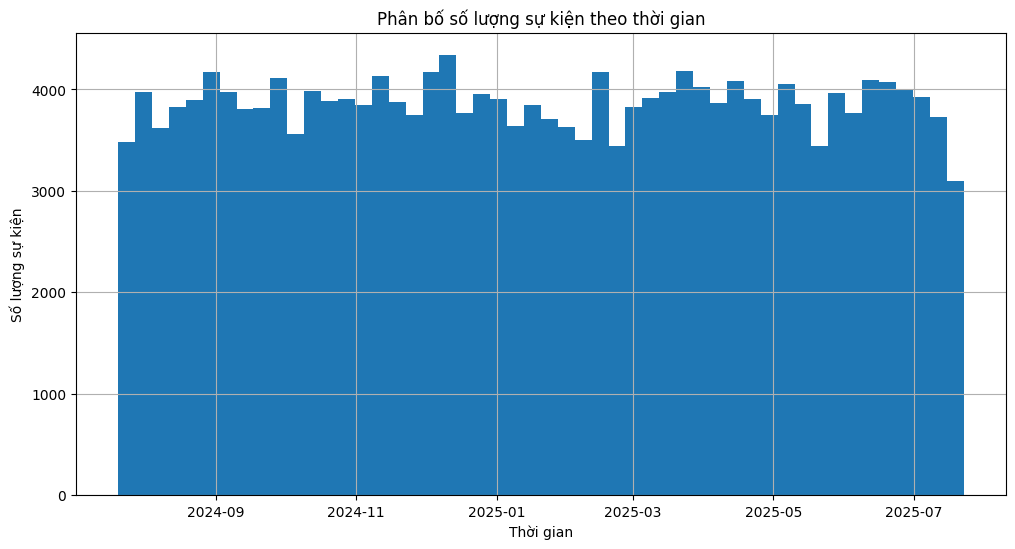

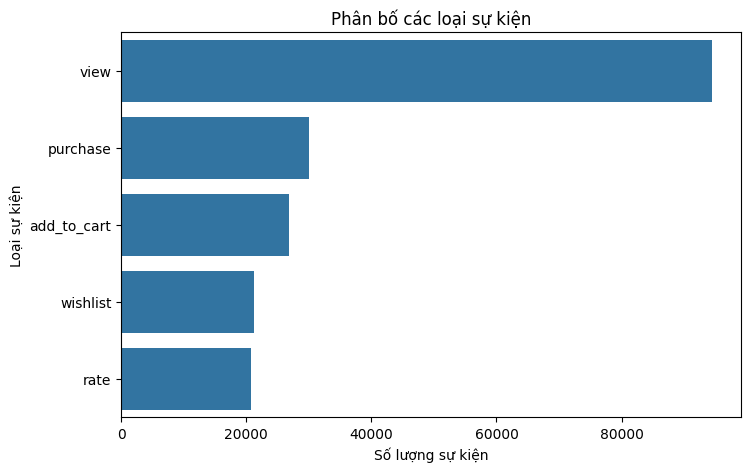

In [6]:
# Cell 3: Tải dữ liệu và Chia tập Train/Validation/Test

# 1. Tải tất cả các sự kiện người dùng
print("--- Bắt đầu tải dữ liệu người dùng từ cơ sở dữ liệu ---")
df_raw_events = load_all_user_events()

if df_raw_events.empty:
    logger.warning("Không tìm thấy sự kiện người dùng nào. Dừng quá trình.")
    # Để đảm bảo các cell sau không bị lỗi, có thể thoát hoặc xử lý đặc biệt
    # raise SystemExit("Không có dữ liệu để xử lý.")
else:
    print("\n--- 5 hàng đầu tiên của dữ liệu sự kiện thô ---")
    print(df_raw_events.head())
    print(f"\nTổng số sự kiện đã tải: {len(df_raw_events)}")
    print(f"Số lượng người dùng duy nhất: {df_raw_events['user_id'].nunique()}")
    print(f"Số lượng sản phẩm duy nhất: {df_raw_events['product_id'].nunique()}")
    print(f"Các loại sự kiện và số lượng: \n{df_raw_events['event_type'].value_counts()}")


# 2. Chia dữ liệu thành tập Train, Validation và Test dựa trên thời gian
print("\n--- Bắt đầu chia tập dữ liệu thành Train, Validation, Test ---")
df_train_raw, df_val_raw, df_test_raw = split_data_time_based(df_raw_events.copy(), train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

print("\n--- Thống kê sau khi chia tập dữ liệu ---")
print(f"Kích thước tập Train: {len(df_train_raw)} sự kiện")
print(f"Kích thước tập Validation: {len(df_val_raw)} sự kiện")
print(f"Kích thước tập Test: {len(df_test_raw)} sự kiện")

print("\n--- 5 hàng đầu tiên của tập Train ---")
print(df_train_raw.head())
print("\n--- 5 hàng đầu tiên của tập Validation ---")
print(df_val_raw.head())
print("\n--- 5 hàng đầu tiên của tập Test ---")
print(df_test_raw.head())

# --- THÊM CÁC KIỂM TRA MỚI VÀO ĐÂY ---
print("\n--- KIỂM TRA SAU KHI CHIA TẬP ---")

# 1. Số lượng người dùng duy nhất trong mỗi tập
print(f"Người dùng duy nhất trong Train: {df_train_raw['user_id'].nunique()}")
print(f"Người dùng duy nhất trong Validation: {df_val_raw['user_id'].nunique()}")
print(f"Người dùng duy nhất trong Test: {df_test_raw['user_id'].nunique()}")

# 2. Số lượng sự kiện 'purchase' trong tập Train
train_purchases_count = df_train_raw[df_train_raw['event_type'] == 'purchase'].shape[0]
print(f"Tổng số sự kiện 'purchase' trong tập Train: {train_purchases_count}")

# 3. Số lượng người dùng có sự kiện 'purchase' trong tập Train
users_with_train_purchases = df_train_raw[df_train_raw['event_type'] == 'purchase']['user_id'].unique()
print(f"Số lượng người dùng có ít nhất 1 sự kiện 'purchase' trong Train: {len(users_with_train_purchases)}")

# 4. Số lượng người dùng có bất kỳ tương tác nào trong tập Validation
users_with_val_interactions = df_val_raw['user_id'].unique()
print(f"Số lượng người dùng có bất kỳ tương tác nào trong Validation: {len(users_with_val_interactions)}")

# 5. Sự giao thoa giữa người dùng có 'purchase' trong Train và người dùng có tương tác trong Validation
common_users_for_eval = set(users_with_train_purchases) & set(users_with_val_interactions)
print(f"Số lượng người dùng đủ điều kiện để đánh giá (mua trong Train & tương tác trong Val): {len(common_users_for_eval)}")

if len(common_users_for_eval) == 0:
    print("!!! CẢNH BÁO: Không có người dùng nào đủ điều kiện để đánh giá mô hình. Điều này sẽ dẫn đến metrics bằng 0.")
    print("Vấn đề có thể do cách chia dữ liệu theo thời gian hoặc dữ liệu quá thưa thớt.")
    # In ra một số ví dụ để kiểm tra thủ công (nếu muốn)
    # print("Một số user_id có purchase trong train:", list(users_with_train_purchases)[:5])
    # print("Một số user_id có tương tác trong validation:", list(users_with_val_interactions)[:5])

print("--- KẾT THÚC KIỂM TRA SAU KHI CHIA TẬP ---\n")
# --- KẾT THÚC CÁC KIỂM TRA MỚI ---


# Trực quan hóa phân bố sự kiện theo thời gian (nếu có đủ dữ liệu)
plt.figure(figsize=(12, 6))
df_raw_events['created_at'].hist(bins=50)
plt.title('Phân bố số lượng sự kiện theo thời gian')
plt.xlabel('Thời gian')
plt.ylabel('Số lượng sự kiện')
plt.grid(True)
plt.show()

# Trực quan hóa phân bố loại sự kiện
plt.figure(figsize=(8, 5))
sns.countplot(y='event_type', data=df_raw_events, order=df_raw_events['event_type'].value_counts().index)
plt.title('Phân bố các loại sự kiện')
plt.xlabel('Số lượng sự kiện')
plt.ylabel('Loại sự kiện')
plt.show()

2025-07-25 09:59:24,643 - INFO - Bắt đầu tải dữ liệu thuộc tính sản phẩm...
2025-07-25 09:59:24,644 - INFO - Đang tải dữ liệu sản phẩm đầy đủ từ cơ sở dữ liệu...
2025-07-25 09:59:24,664 - INFO - Đã tải và gộp thành công 18 sản phẩm gốc.
2025-07-25 09:59:24,664 - INFO - Đã tải 18 sản phẩm với thuộc tính.
2025-07-25 09:59:24,664 - INFO - Sample features_text:
2025-07-25 09:59:24,664 - INFO -   Product ID 56: 16 256gb 512gb 8gb amoled apple công hình hồng iphone màn màu nghệ oled sắc thoại trắng vàng xám đen điện đỏ đồng...
2025-07-25 09:59:24,664 - INFO -   Product ID 58: 256gb 2x 5g 8gb amodled công dynamic galaxy hình màn màu nghệ s25 samsung sắc thoại ultra đen điện...
2025-07-25 09:59:24,664 - INFO -   Product ID 59: 128gb 16e 256gb 8gb apple công hình iphone màn màu nghệ oled sắc thoại trắng đen điện...
2025-07-25 09:59:24,664 - INFO -   Product ID 61: 16gb 512gb 5g amoled công find hình ltpo màn màu n5 nghệ oppo sắc thoại đen điện...
2025-07-25 09:59:24,671 - INFO -   Product ID 62


--- Bắt đầu quá trình tối ưu hóa trọng số Implicit Feedback cho Hệ thống Lai bằng Bayesian Optimization ---

--- Đang tải và xử lý dữ liệu thuộc tính sản phẩm cho Content-based Filtering ---


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PC\.cache\huggingface\hub\models--vinai--phobert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-07-25 09:59:32,846 - WARNING - From C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



tf_model.h5:   0%|          | 0.00/740M [00:00<?, ?B/s]

2025-07-25 10:02:30,421 - WARNING - From C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\tf_keras\src\backend.py:873: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers 

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0110
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0010
Function value obtained: 1.0000
Current minimum: 1.0000
Iteration No: 3 started. Evaluating function at random point.


2025-07-25 10:02:33,388 - INFO - DEBUGGING ALPHA: For p1=61 (Interactions: 4100), cold_start_threshold=1, dynamic_alpha used: 0.0071
2025-07-25 10:02:33,390 - INFO - DEBUGGING ALPHA: For p1=62 (Interactions: 4333), cold_start_threshold=1, dynamic_alpha used: 0.0071
2025-07-25 10:02:33,390 - INFO - DEBUGGING ALPHA: For p1=63 (Interactions: 4323), cold_start_threshold=1, dynamic_alpha used: 0.0071
2025-07-25 10:02:33,392 - INFO - Finished combining similarities for 19 products, now including detailed scores and dynamic alpha.
2025-07-25 10:02:33,392 - INFO - Số lượng item có độ tương đồng lai: 19
2025-07-25 10:02:33,394 - INFO - Số lượng item có độ tương đồng lai (sau khi lọc final_hybrid_threshold): 19
2025-07-25 10:02:33,461 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:33,552 - INFO - DEBUG_OBJ: NDCG@15: 0.3544, Optimization Score: -0.3544
2025-07-25 10:02:33,552 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.10466656632136155, 'add_to_cart': 0.68

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3380
Function value obtained: -0.3544
Current minimum: -0.3544
Iteration No: 4 started. Evaluating function at random point.


2025-07-25 10:02:33,793 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:33,878 - INFO - DEBUG_OBJ: NDCG@15: 0.3673, Optimization Score: -0.3673
2025-07-25 10:02:33,880 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.146676289324798, 'add_to_cart': 0.6299702033681603, 'wishlist': 0.30409226157633396, 'purchase': 1.0}, alpha lai: 0.4504992519695431, cold_start_threshold: 1
2025-07-25 10:02:33,995 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:34,003 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:34,007 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:34,008 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:34,010 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3279
Function value obtained: -0.3673
Current minimum: -0.3673
Iteration No: 5 started. Evaluating function at random point.


2025-07-25 10:02:34,136 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:34,215 - INFO - DEBUG_OBJ: NDCG@15: 0.3796, Optimization Score: -0.3796
2025-07-25 10:02:34,217 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13854165025399162, 'add_to_cart': 0.2079831261101071, 'wishlist': 0.16926814768664472, 'purchase': 1.0}, alpha lai: 0.24102546602601177, cold_start_threshold: 14
2025-07-25 10:02:34,310 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:34,320 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:34,323 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:34,325 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:34,326 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, 

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3364
Function value obtained: -0.3796
Current minimum: -0.3796
Iteration No: 6 started. Evaluating function at random point.


2025-07-25 10:02:34,455 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:34,532 - INFO - DEBUG_OBJ: NDCG@15: 0.3709, Optimization Score: -0.3709
2025-07-25 10:02:34,536 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.11733646535077721, 'add_to_cart': 0.39553030378662046, 'wishlist': 0.1546708263364187, 'purchase': 1.0}, alpha lai: 0.7553614103176527, cold_start_threshold: 9
2025-07-25 10:02:34,632 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:34,641 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:34,645 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:34,647 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:34,647 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.3185
Function value obtained: -0.3709
Current minimum: -0.3796
Iteration No: 7 started. Evaluating function at random point.


2025-07-25 10:02:34,774 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:34,845 - INFO - DEBUG_OBJ: NDCG@15: 0.4026, Optimization Score: -0.4026
2025-07-25 10:02:34,847 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.10313132924555586, 'add_to_cart': 0.6211423872974993, 'wishlist': 0.23492624001092977, 'purchase': 1.0}, alpha lai: 0.39515023600181454, cold_start_threshold: 19
2025-07-25 10:02:34,941 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:34,951 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:34,954 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:34,956 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:34,958 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, 

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 0.3117
Function value obtained: -0.4026
Current minimum: -0.4026
Iteration No: 8 started. Evaluating function at random point.


2025-07-25 10:02:35,083 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:35,162 - INFO - DEBUG_OBJ: NDCG@15: 0.3779, Optimization Score: -0.3779
2025-07-25 10:02:35,164 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.15704439744053997, 'add_to_cart': 0.46041713001291185, 'wishlist': 0.3883516073048049, 'purchase': 1.0}, alpha lai: 0.8445338486781516, cold_start_threshold: 15
2025-07-25 10:02:35,258 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:35,263 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:35,263 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:35,263 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:35,263 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, m

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.3167
Function value obtained: -0.3779
Current minimum: -0.4026
Iteration No: 9 started. Evaluating function at random point.


2025-07-25 10:02:35,403 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:35,479 - INFO - DEBUG_OBJ: NDCG@15: 0.4347, Optimization Score: -0.4347
2025-07-25 10:02:35,481 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.19652553072641382, 'add_to_cart': 0.5035171238433424, 'wishlist': 0.18279975460676304, 'purchase': 1.0}. Trả về 1.0.
2025-07-25 10:02:35,483 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.139488151817557, 'add_to_cart': 0.34674408735901907, 'wishlist': 0.10422394681452535, 'purchase': 1.0}. Trả về 1.0.
2025-07-25 10:02:35,484 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.19263008785133492, 'add_to_cart': 0.5255385127509722, 'wishlist': 0.37448790266313436, 'purchase': 1.0}, alpha lai: 0.8500385777897995, cold_start_threshold: 10
2025-07-25 10:02:35,579 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.3186
Function value obtained: -0.4347
Current minimum: -0.4347
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.0010
Function value obtained: 1.0000
Current minimum: -0.4347
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.0009
Function value obtained: 1.0000
Current minimum: -0.4347
Iteration No: 12 started. Evaluating function at random point.


2025-07-25 10:02:35,898 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:35,976 - INFO - DEBUG_OBJ: NDCG@15: 0.4447, Optimization Score: -0.4447
2025-07-25 10:02:35,979 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.16688412526636076, 'add_to_cart': 0.5329611783087483, 'wishlist': 0.2773893363123182, 'purchase': 1.0}, alpha lai: 0.2747217929900642, cold_start_threshold: 12
2025-07-25 10:02:36,074 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:36,082 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:36,082 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:36,082 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:36,082 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 0.4942
Function value obtained: -0.4447
Current minimum: -0.4447
Iteration No: 13 started. Evaluating function at random point.


2025-07-25 10:02:36,215 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:36,293 - INFO - DEBUG_OBJ: NDCG@15: 0.3734, Optimization Score: -0.3734
2025-07-25 10:02:36,296 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.1848913824266084, 'add_to_cart': 0.5608647605824366, 'wishlist': 0.17079547592468675, 'purchase': 1.0}. Trả về 1.0.
2025-07-25 10:02:36,298 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.14393365018657703, 'add_to_cart': 0.3008596011676981, 'wishlist': 0.36872907870205596, 'purchase': 1.0}. Trả về 1.0.
2025-07-25 10:02:36,299 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.16044173792778174, 'add_to_cart': 0.4699205456508366, 'wishlist': 0.16091836742043086, 'purchase': 1.0}, alpha lai: 0.9428535705579812, cold_start_threshold: 12
2025-07-25 10:02:36,394 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 0.3177
Function value obtained: -0.3734
Current minimum: -0.4447
Iteration No: 14 started. Evaluating function at random point.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 0.0015
Function value obtained: 1.0000
Current minimum: -0.4447
Iteration No: 15 started. Evaluating function at random point.
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 0.0011
Function value obtained: 1.0000
Current minimum: -0.4447
Iteration No: 16 started. Evaluating function at random point.


2025-07-25 10:02:36,535 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:36,581 - INFO - DEBUG_OBJ: NDCG@15: 0.3099, Optimization Score: -0.3099
2025-07-25 10:02:36,581 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.16243540481337934, 'add_to_cart': 0.347816842918857, 'wishlist': 0.1316482779490812, 'purchase': 1.0}. Trả về 1.0.
2025-07-25 10:02:36,595 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1324345021005274, 'add_to_cart': 0.2610439773503367, 'wishlist': 0.2068893514230925, 'purchase': 1.0}, alpha lai: 0.9068284415457543, cold_start_threshold: 6
2025-07-25 10:02:36,692 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:36,697 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:36,697 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 200

Iteration No: 16 ended. Evaluation done at random point.
Time taken: 0.2835
Function value obtained: -0.3099
Current minimum: -0.4447
Iteration No: 17 started. Evaluating function at random point.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 0.0138
Function value obtained: 1.0000
Current minimum: -0.4447
Iteration No: 18 started. Evaluating function at random point.


2025-07-25 10:02:36,854 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:36,935 - INFO - DEBUG_OBJ: NDCG@15: 0.4455, Optimization Score: -0.4455
2025-07-25 10:02:36,937 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13525688563341692, 'add_to_cart': 0.35239062907901453, 'wishlist': 0.14939675594288254, 'purchase': 1.0}, alpha lai: 0.5340894193754421, cold_start_threshold: 10
2025-07-25 10:02:37,032 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:37,037 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:37,045 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:37,046 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:37,048 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, 

Iteration No: 18 ended. Evaluation done at random point.
Time taken: 0.3404
Function value obtained: -0.4455
Current minimum: -0.4455
Iteration No: 19 started. Evaluating function at random point.


2025-07-25 10:02:37,176 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:37,253 - INFO - DEBUG_OBJ: NDCG@15: 0.3812, Optimization Score: -0.3812
2025-07-25 10:02:37,256 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.12441255222477743, 'add_to_cart': 0.2841455210864653, 'wishlist': 0.16562926587192112, 'purchase': 1.0}, alpha lai: 0.5581020020173413, cold_start_threshold: 9
2025-07-25 10:02:37,342 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:37,361 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:37,361 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:37,361 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:37,361 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 19 ended. Evaluation done at random point.
Time taken: 0.3187
Function value obtained: -0.3812
Current minimum: -0.4455
Iteration No: 20 started. Evaluating function at random point.


2025-07-25 10:02:37,479 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:37,560 - INFO - DEBUG_OBJ: NDCG@15: 0.3821, Optimization Score: -0.3821
2025-07-25 10:02:37,999 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1260255044022785, 'add_to_cart': 0.3540043986162599, 'wishlist': 0.1572518991370537, 'purchase': 1.0}, alpha lai: 0.6322149347108594, cold_start_threshold: 7
2025-07-25 10:02:38,094 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:38,095 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:38,095 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:38,095 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:38,095 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 0.7441
Function value obtained: -0.3821
Current minimum: -0.4455
Iteration No: 21 started. Searching for the next optimal point.


2025-07-25 10:02:38,237 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:38,315 - INFO - DEBUG_OBJ: NDCG@15: 0.3947, Optimization Score: -0.3947
2025-07-25 10:02:38,918 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.16229449346661054, 'add_to_cart': 0.7, 'wishlist': 0.4, 'purchase': 1.0}, alpha lai: 0.0, cold_start_threshold: 20
2025-07-25 10:02:39,012 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:39,021 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:39,021 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:39,028 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:39,029 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:02:39,030 - INFO -

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.9176
Function value obtained: -0.3947
Current minimum: -0.4455
Iteration No: 22 started. Searching for the next optimal point.


2025-07-25 10:02:39,145 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:39,235 - INFO - DEBUG_OBJ: NDCG@15: 0.3494, Optimization Score: -0.3494
2025-07-25 10:02:39,809 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13749933020810487, 'add_to_cart': 0.4271681228317763, 'wishlist': 0.17349354714061976, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:39,910 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:39,925 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:39,929 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:39,930 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:39,931 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.8912
Function value obtained: -0.3494
Current minimum: -0.4455
Iteration No: 23 started. Searching for the next optimal point.


2025-07-25 10:02:40,060 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:40,128 - INFO - DEBUG_OBJ: NDCG@15: 0.4416, Optimization Score: -0.4416
2025-07-25 10:02:40,646 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.16102636429909972, 'add_to_cart': 0.4971464418499577, 'wishlist': 0.391236785358704, 'purchase': 1.0}, alpha lai: 0.8864023391347149, cold_start_threshold: 15
2025-07-25 10:02:40,740 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:40,747 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:40,747 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:40,747 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:40,747 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.8361
Function value obtained: -0.4416
Current minimum: -0.4455
Iteration No: 24 started. Searching for the next optimal point.


2025-07-25 10:02:40,883 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:40,951 - INFO - DEBUG_OBJ: NDCG@15: 0.3930, Optimization Score: -0.3930
2025-07-25 10:02:41,398 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.2, 'add_to_cart': 0.7, 'wishlist': 0.31434214608311295, 'purchase': 1.0}, alpha lai: 0.6318938574565875, cold_start_threshold: 19
2025-07-25 10:02:41,494 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:41,501 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:41,501 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:41,501 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:41,501 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:02:

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.7522
Function value obtained: -0.3930
Current minimum: -0.4455
Iteration No: 25 started. Searching for the next optimal point.


2025-07-25 10:02:41,654 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:41,733 - INFO - DEBUG_OBJ: NDCG@15: 0.3951, Optimization Score: -0.3951
2025-07-25 10:02:42,193 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1741434201803066, 'add_to_cart': 0.6298840699349733, 'wishlist': 0.28778042417420757, 'purchase': 1.0}, alpha lai: 0.2957351761037885, cold_start_threshold: 8
2025-07-25 10:02:42,293 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:42,307 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:42,311 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:42,312 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:42,314 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.7950
Function value obtained: -0.3951
Current minimum: -0.4455
Iteration No: 26 started. Searching for the next optimal point.


2025-07-25 10:02:42,440 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:42,510 - INFO - DEBUG_OBJ: NDCG@15: 0.3747, Optimization Score: -0.3747
2025-07-25 10:02:42,996 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.18462829694618937, 'add_to_cart': 0.5683685092391548, 'wishlist': 0.3804633313783967, 'purchase': 1.0}, alpha lai: 0.8602388752548693, cold_start_threshold: 12
2025-07-25 10:02:43,092 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:43,100 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:43,100 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:43,100 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:43,100 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.8024
Function value obtained: -0.3747
Current minimum: -0.4455
Iteration No: 27 started. Searching for the next optimal point.


2025-07-25 10:02:43,228 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:43,309 - INFO - DEBUG_OBJ: NDCG@15: 0.4467, Optimization Score: -0.4467
2025-07-25 10:02:43,822 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14121516730208766, 'add_to_cart': 0.4571640908336031, 'wishlist': 0.16757024435949092, 'purchase': 1.0}, alpha lai: 0.9957649403570668, cold_start_threshold: 8
2025-07-25 10:02:43,918 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:43,934 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:43,934 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:43,934 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:43,934 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8257
Function value obtained: -0.4467
Current minimum: -0.4467
Iteration No: 28 started. Searching for the next optimal point.


2025-07-25 10:02:44,062 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:44,112 - INFO - DEBUG_OBJ: NDCG@15: 0.3274, Optimization Score: -0.3274
2025-07-25 10:02:44,662 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14188423701326627, 'add_to_cart': 0.6877074518229507, 'wishlist': 0.2672706600100814, 'purchase': 1.0}, alpha lai: 0.9712284258295844, cold_start_threshold: 20
2025-07-25 10:02:44,755 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:44,766 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:44,769 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:44,770 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:44,772 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.8395
Function value obtained: -0.3274
Current minimum: -0.4467
Iteration No: 29 started. Searching for the next optimal point.


2025-07-25 10:02:44,896 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:44,962 - INFO - DEBUG_OBJ: NDCG@15: 0.4351, Optimization Score: -0.4351
2025-07-25 10:02:45,550 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14994497570318055, 'add_to_cart': 0.7, 'wishlist': 0.3450349507738089, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 17
2025-07-25 10:02:45,644 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:45,654 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:45,657 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:45,658 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:45,659 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:02:

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.8879
Function value obtained: -0.4351
Current minimum: -0.4467
Iteration No: 30 started. Searching for the next optimal point.


2025-07-25 10:02:45,785 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:45,864 - INFO - DEBUG_OBJ: NDCG@15: 0.4426, Optimization Score: -0.4426
2025-07-25 10:02:46,474 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13733694909707367, 'add_to_cart': 0.32525796940505625, 'wishlist': 0.19277348906085343, 'purchase': 1.0}, alpha lai: 0.8937805770092073, cold_start_threshold: 20
2025-07-25 10:02:46,571 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:46,581 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:46,583 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:46,585 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:46,587 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, 

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.9240
Function value obtained: -0.4426
Current minimum: -0.4467
Iteration No: 31 started. Searching for the next optimal point.


2025-07-25 10:02:46,715 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:46,796 - INFO - DEBUG_OBJ: NDCG@15: 0.4452, Optimization Score: -0.4452
2025-07-25 10:02:47,280 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1898701435863378, 'add_to_cart': 0.5822283486426719, 'wishlist': 0.37679350841468007, 'purchase': 1.0}, alpha lai: 0.8904136171365602, cold_start_threshold: 11
2025-07-25 10:02:47,373 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:47,383 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:47,386 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:47,387 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:47,390 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.8061
Function value obtained: -0.4452
Current minimum: -0.4467
Iteration No: 32 started. Searching for the next optimal point.


2025-07-25 10:02:47,516 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:47,596 - INFO - DEBUG_OBJ: NDCG@15: 0.4449, Optimization Score: -0.4449
2025-07-25 10:02:48,138 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1270244114951713, 'add_to_cart': 0.3686818656691022, 'wishlist': 0.15392931438502572, 'purchase': 1.0}, alpha lai: 0.5829327198477708, cold_start_threshold: 20
2025-07-25 10:02:48,217 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:48,233 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:48,233 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:48,233 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:48,233 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.8421
Function value obtained: -0.4449
Current minimum: -0.4467
Iteration No: 33 started. Searching for the next optimal point.


2025-07-25 10:02:48,536 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:48,614 - INFO - DEBUG_OBJ: NDCG@15: 0.3820, Optimization Score: -0.3820
2025-07-25 10:02:49,126 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14592058191088605, 'add_to_cart': 0.6937351572931969, 'wishlist': 0.2906952810312504, 'purchase': 1.0}, alpha lai: 0.6433522640645872, cold_start_threshold: 12
2025-07-25 10:02:49,220 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:49,231 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:49,234 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:49,237 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:49,238 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.9876
Function value obtained: -0.3820
Current minimum: -0.4467
Iteration No: 34 started. Searching for the next optimal point.


2025-07-25 10:02:49,365 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:49,427 - INFO - DEBUG_OBJ: NDCG@15: 0.4008, Optimization Score: -0.4008
2025-07-25 10:02:50,075 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13710348325323743, 'add_to_cart': 0.4093907664633415, 'wishlist': 0.17606266501186715, 'purchase': 1.0}, alpha lai: 0.9992262469645307, cold_start_threshold: 16
2025-07-25 10:02:50,171 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:50,186 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:50,186 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:50,186 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:50,186 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, m

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.9494
Function value obtained: -0.4008
Current minimum: -0.4467
Iteration No: 35 started. Searching for the next optimal point.


2025-07-25 10:02:50,314 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:50,403 - INFO - DEBUG_OBJ: NDCG@15: 0.4417, Optimization Score: -0.4417
2025-07-25 10:02:51,122 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.5149367356962962, 'wishlist': 0.2086513994057539, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:51,218 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:51,234 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:51,234 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:51,234 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:51,234 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:02:5

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 1.0471
Function value obtained: -0.4417
Current minimum: -0.4467
Iteration No: 36 started. Searching for the next optimal point.


2025-07-25 10:02:51,361 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:51,441 - INFO - DEBUG_OBJ: NDCG@15: 0.4386, Optimization Score: -0.4386
2025-07-25 10:02:52,139 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.2, 'add_to_cart': 0.7, 'wishlist': 0.36987474689464894, 'purchase': 1.0}, alpha lai: 0.2824381116788566, cold_start_threshold: 5
2025-07-25 10:02:52,237 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:52,249 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:52,249 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:52,249 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:52,249 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:02:5

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.0166
Function value obtained: -0.4386
Current minimum: -0.4467
Iteration No: 37 started. Searching for the next optimal point.


2025-07-25 10:02:52,384 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:52,470 - INFO - DEBUG_OBJ: NDCG@15: 0.3741, Optimization Score: -0.3741
2025-07-25 10:02:53,056 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13664368185834044, 'add_to_cart': 0.3793844442993273, 'wishlist': 0.18124740884488147, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:53,154 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:53,167 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:53,167 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:53,167 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:53,167 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.9167
Function value obtained: -0.3741
Current minimum: -0.4467
Iteration No: 38 started. Searching for the next optimal point.


2025-07-25 10:02:53,295 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:53,374 - INFO - DEBUG_OBJ: NDCG@15: 0.4419, Optimization Score: -0.4419
2025-07-25 10:02:54,058 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.12816240095629786, 'add_to_cart': 0.4199370956307746, 'wishlist': 0.1753793796224733, 'purchase': 1.0}, alpha lai: 0.9705853580609798, cold_start_threshold: 20
2025-07-25 10:02:54,154 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:54,170 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:54,170 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:54,170 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:54,170 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 1.0025
Function value obtained: -0.4419
Current minimum: -0.4467
Iteration No: 39 started. Searching for the next optimal point.


2025-07-25 10:02:54,303 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:54,344 - INFO - DEBUG_OBJ: NDCG@15: 0.2703, Optimization Score: -0.2703
2025-07-25 10:02:54,978 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.1473771387198701, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:55,063 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:55,078 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:55,078 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:55,078 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:55,078 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:02:55,078 - INFO - 

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.9093
Function value obtained: -0.2703
Current minimum: -0.4467
Iteration No: 40 started. Searching for the next optimal point.


2025-07-25 10:02:55,206 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:55,286 - INFO - DEBUG_OBJ: NDCG@15: 0.4353, Optimization Score: -0.4353
2025-07-25 10:02:55,925 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14409560672259425, 'add_to_cart': 0.4202446324887713, 'wishlist': 0.1695534948488398, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:02:56,022 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:56,030 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:56,032 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:56,034 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:56,036 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.9579
Function value obtained: -0.4353
Current minimum: -0.4467
Iteration No: 41 started. Searching for the next optimal point.


2025-07-25 10:02:56,163 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:56,242 - INFO - DEBUG_OBJ: NDCG@15: 0.4418, Optimization Score: -0.4418
2025-07-25 10:02:56,825 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14460165058915678, 'add_to_cart': 0.41789024605207065, 'wishlist': 0.17192726168729883, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 17
2025-07-25 10:02:56,920 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:56,936 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:56,936 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:56,936 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:56,936 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.8994
Function value obtained: -0.4418
Current minimum: -0.4467
Iteration No: 42 started. Searching for the next optimal point.


2025-07-25 10:02:57,066 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:57,141 - INFO - DEBUG_OBJ: NDCG@15: 0.4418, Optimization Score: -0.4418
2025-07-25 10:02:57,688 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.158275530712382, 'add_to_cart': 0.4797708144265943, 'wishlist': 0.3895879040437582, 'purchase': 1.0}, alpha lai: 0.8890901123349847, cold_start_threshold: 6
2025-07-25 10:02:57,773 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:57,789 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:57,789 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:57,789 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:57,789 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_s

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.8635
Function value obtained: -0.4418
Current minimum: -0.4467
Iteration No: 43 started. Searching for the next optimal point.


2025-07-25 10:02:57,916 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:58,001 - INFO - DEBUG_OBJ: NDCG@15: 0.4461, Optimization Score: -0.4461
2025-07-25 10:02:58,582 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.11276466084198969, 'add_to_cart': 0.41856166574071, 'wishlist': 0.1469214474519172, 'purchase': 1.0}, alpha lai: 0.8437107472180714, cold_start_threshold: 7
2025-07-25 10:02:58,677 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:58,686 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:58,688 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:58,691 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:58,693 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_s

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.8939
Function value obtained: -0.4461
Current minimum: -0.4467
Iteration No: 44 started. Searching for the next optimal point.


2025-07-25 10:02:58,809 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:58,889 - INFO - DEBUG_OBJ: NDCG@15: 0.4457, Optimization Score: -0.4457
2025-07-25 10:02:59,429 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.4, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 2
2025-07-25 10:02:59,524 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:02:59,540 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:02:59,540 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:02:59,540 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:02:59,540 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:02:59,540 - INFO - Đang tính toán m

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.8473
Function value obtained: -0.4457
Current minimum: -0.4467
Iteration No: 45 started. Searching for the next optimal point.


2025-07-25 10:02:59,670 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:02:59,742 - INFO - DEBUG_OBJ: NDCG@15: 0.4376, Optimization Score: -0.4376
2025-07-25 10:03:00,378 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13421725208091645, 'add_to_cart': 0.6064909266789711, 'wishlist': 0.4, 'purchase': 1.0}, alpha lai: 0.506030235440915, cold_start_threshold: 1
2025-07-25 10:03:00,478 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:00,478 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:00,494 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:00,494 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:00,494 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.9488
Function value obtained: -0.4376
Current minimum: -0.4467
Iteration No: 46 started. Searching for the next optimal point.


2025-07-25 10:03:00,621 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:00,703 - INFO - DEBUG_OBJ: NDCG@15: 0.3811, Optimization Score: -0.3811
2025-07-25 10:03:01,327 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1430953735304573, 'add_to_cart': 0.3208101881495419, 'wishlist': 0.19368581686214725, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:01,413 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:01,431 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:01,433 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:01,435 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:01,437 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.9475
Function value obtained: -0.3811
Current minimum: -0.4467
Iteration No: 47 started. Searching for the next optimal point.


2025-07-25 10:03:01,562 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:01,640 - INFO - DEBUG_OBJ: NDCG@15: 0.4447, Optimization Score: -0.4447
2025-07-25 10:03:02,371 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.12632690019985862, 'add_to_cart': 0.6245021701973534, 'wishlist': 0.16813152868908043, 'purchase': 1.0}, alpha lai: 0.9715915350338596, cold_start_threshold: 18
2025-07-25 10:03:02,467 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:02,476 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:02,478 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:02,479 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:02,481 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, m

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.0440
Function value obtained: -0.4447
Current minimum: -0.4467
Iteration No: 48 started. Searching for the next optimal point.


2025-07-25 10:03:02,604 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:02,681 - INFO - DEBUG_OBJ: NDCG@15: 0.4329, Optimization Score: -0.4329
2025-07-25 10:03:03,227 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1957856531913898, 'add_to_cart': 0.6315422229443958, 'wishlist': 0.270636027251978, 'purchase': 1.0}, alpha lai: 0.29372093287286055, cold_start_threshold: 3
2025-07-25 10:03:03,323 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:03,333 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:03,334 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:03,336 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:03,337 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.8559
Function value obtained: -0.4329
Current minimum: -0.4467
Iteration No: 49 started. Searching for the next optimal point.


2025-07-25 10:03:03,463 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:03,541 - INFO - DEBUG_OBJ: NDCG@15: 0.3743, Optimization Score: -0.3743
2025-07-25 10:03:04,083 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.12511506007151665, 'add_to_cart': 0.22768138913191668, 'wishlist': 0.2081028694566194, 'purchase': 1.0}, alpha lai: 0.23713529502117225, cold_start_threshold: 13
2025-07-25 10:03:04,180 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:04,189 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:04,192 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:04,193 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:04,195 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, 

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.8578
Function value obtained: -0.3743
Current minimum: -0.4467
Iteration No: 50 started. Searching for the next optimal point.


2025-07-25 10:03:04,332 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:04,408 - INFO - DEBUG_OBJ: NDCG@15: 0.3711, Optimization Score: -0.3711
2025-07-25 10:03:05,013 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.19060301059135387, 'add_to_cart': 0.26696889352196135, 'wishlist': 0.28928833808299964, 'purchase': 1.0}. Trả về 1.0.


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.9294
Function value obtained: -0.3711
Current minimum: -0.4467
Iteration No: 51 started. Searching for the next optimal point.


2025-07-25 10:03:05,679 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.31776405213570086, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 19
2025-07-25 10:03:05,761 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:05,776 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:05,776 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:05,776 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:05,776 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:03:05,776 - INFO - Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...
2025-07-25 10:03:05,792 - INFO - DEBUG_SIM: Kích thước DataFrame đã lọc (implicit_score > 0): 

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.6662
Function value obtained: 1.0000
Current minimum: -0.4467
Iteration No: 52 started. Searching for the next optimal point.


2025-07-25 10:03:05,903 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:05,989 - INFO - DEBUG_OBJ: NDCG@15: 0.4385, Optimization Score: -0.4385
2025-07-25 10:03:06,628 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13103898950283158, 'add_to_cart': 0.21102891055168557, 'wishlist': 0.18335518745205384, 'purchase': 1.0}, alpha lai: 0.32058283820415995, cold_start_threshold: 11
2025-07-25 10:03:06,727 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:06,730 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:06,730 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:06,730 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:06,730 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00,

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 0.9495
Function value obtained: -0.4385
Current minimum: -0.4467
Iteration No: 53 started. Searching for the next optimal point.


2025-07-25 10:03:06,866 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:06,944 - INFO - DEBUG_OBJ: NDCG@15: 0.3753, Optimization Score: -0.3753
2025-07-25 10:03:07,580 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1208988631786828, 'add_to_cart': 0.6464576305532335, 'wishlist': 0.1694220095776317, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:07,697 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:07,710 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:07,712 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:07,712 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:07,718 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
202

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 0.9513
Function value obtained: -0.3753
Current minimum: -0.4467
Iteration No: 54 started. Searching for the next optimal point.


2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=74 (Interactions: 0), cold_start_threshold=20, dynamic_alpha used: 0.1000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=56 (Interactions: 23848), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=57 (Interactions: 4331), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=58 (Interactions: 4092), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=59 (Interactions: 7451), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=60 (Interactions: 7321), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=61 (Interactions: 4100), cold_start_threshold=20, dynamic_alpha used: 1.0000
2025-07-25 10:03:07,761 - INFO - DEBUGGING ALPHA: For p1=62 (Int

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.9301
Function value obtained: -0.4343
Current minimum: -0.4467
Iteration No: 55 started. Searching for the next optimal point.


2025-07-25 10:03:09,208 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1439682426133459, 'add_to_cart': 0.5227821067342973, 'wishlist': 0.2305819976499423, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:09,304 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:09,304 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:09,320 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:09,320 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:09,320 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:03:09,320 - INFO - Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...
2025-07-25 10:03:09,320 - INFO - DEBUG_SIM: Kích thước DataFrame 

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.6985
Function value obtained: 1.0000
Current minimum: -0.4467
Iteration No: 56 started. Searching for the next optimal point.


2025-07-25 10:03:09,446 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:09,527 - INFO - DEBUG_OBJ: NDCG@15: 0.4445, Optimization Score: -0.4445
2025-07-25 10:03:10,137 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.429550709822515, 'wishlist': 0.18791764089200808, 'purchase': 1.0}, alpha lai: 0.0, cold_start_threshold: 11
2025-07-25 10:03:10,244 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:10,248 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:10,248 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:10,248 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:10,248 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:03:1

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.9290
Function value obtained: -0.4445
Current minimum: -0.4467
Iteration No: 57 started. Searching for the next optimal point.


2025-07-25 10:03:10,390 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:10,470 - INFO - DEBUG_OBJ: NDCG@15: 0.3494, Optimization Score: -0.3494
2025-07-25 10:03:11,081 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13945939258577486, 'add_to_cart': 0.6645957808547815, 'wishlist': 0.34574971201558924, 'purchase': 1.0}, alpha lai: 0.9951549936224016, cold_start_threshold: 18
2025-07-25 10:03:11,176 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:11,192 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:11,192 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:11,192 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:11,192 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, m

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 0.9438
Function value obtained: -0.3494
Current minimum: -0.4467
Iteration No: 58 started. Searching for the next optimal point.


2025-07-25 10:03:11,320 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:11,400 - INFO - DEBUG_OBJ: NDCG@15: 0.4422, Optimization Score: -0.4422
2025-07-25 10:03:12,027 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.5847713014575076, 'wishlist': 0.1527616558214902, 'purchase': 1.0}, alpha lai: 0.7351395023442145, cold_start_threshold: 5
2025-07-25 10:03:12,130 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:12,139 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:12,139 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:12,139 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:12,139 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.9459
Function value obtained: -0.4422
Current minimum: -0.4467
Iteration No: 59 started. Searching for the next optimal point.


2025-07-25 10:03:12,264 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:12,343 - INFO - DEBUG_OBJ: NDCG@15: 0.4400, Optimization Score: -0.4400
2025-07-25 10:03:13,067 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.12422768166693428, 'add_to_cart': 0.5673543582873912, 'wishlist': 0.2347699795208021, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:13,163 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:13,179 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:13,179 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:13,179 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:13,179 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 1.0402
Function value obtained: -0.4400
Current minimum: -0.4467
Iteration No: 60 started. Searching for the next optimal point.


2025-07-25 10:03:13,307 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:13,392 - INFO - DEBUG_OBJ: NDCG@15: 0.4378, Optimization Score: -0.4378
2025-07-25 10:03:13,956 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.121322320409332, 'add_to_cart': 0.416756431335085, 'wishlist': 0.10912511588768102, 'purchase': 1.0}. Trả về 1.0.


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 0.8887
Function value obtained: -0.4378
Current minimum: -0.4467
Iteration No: 61 started. Searching for the next optimal point.


2025-07-25 10:03:14,682 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.3741481654328428, 'purchase': 1.0}, alpha lai: 0.0, cold_start_threshold: 12
2025-07-25 10:03:14,779 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:14,789 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:14,791 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:14,793 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:14,794 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:03:14,795 - INFO - Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...
2025-07-25 10:03:14,812 - INFO - DEBUG_SIM: Kích thước DataFrame đã lọc (implicit_score > 0): 1

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 0.7266
Function value obtained: 1.0000
Current minimum: -0.4467
Iteration No: 62 started. Searching for the next optimal point.


2025-07-25 10:03:14,930 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:15,014 - INFO - DEBUG_OBJ: NDCG@15: 0.3494, Optimization Score: -0.3494
2025-07-25 10:03:15,832 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14377069910143322, 'add_to_cart': 0.37285085407866014, 'wishlist': 0.3308490833064016, 'purchase': 1.0}, alpha lai: 0.29875311368366947, cold_start_threshold: 10
2025-07-25 10:03:15,931 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:15,934 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:15,934 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:15,934 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:15,946 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, 

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 1.1497
Function value obtained: -0.3494
Current minimum: -0.4467
Iteration No: 63 started. Searching for the next optimal point.


2025-07-25 10:03:16,232 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:16,317 - INFO - DEBUG_OBJ: NDCG@15: 0.3744, Optimization Score: -0.3744
2025-07-25 10:03:17,110 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.2, 'add_to_cart': 0.2, 'wishlist': 0.30456674937032735, 'purchase': 1.0}. Trả về 1.0.


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 1.2769
Function value obtained: -0.3744
Current minimum: -0.4467
Iteration No: 64 started. Searching for the next optimal point.


2025-07-25 10:03:17,904 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13584138506178364, 'add_to_cart': 0.41750657866500884, 'wishlist': 0.3303252457455485, 'purchase': 1.0}, alpha lai: 0.04202136723752232, cold_start_threshold: 12
2025-07-25 10:03:18,000 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:18,008 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:18,008 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:18,013 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:18,015 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:03:18,015 - INFO - Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...
2025-07-25 10:03:18,025 - INFO - DEBUG_SIM: Kíc

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 0.7926
Function value obtained: 1.0000
Current minimum: -0.4467
Iteration No: 65 started. Searching for the next optimal point.


2025-07-25 10:03:18,143 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:18,223 - INFO - DEBUG_OBJ: NDCG@15: 0.3637, Optimization Score: -0.3637
2025-07-25 10:03:19,006 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.15333303483333963, 'add_to_cart': 0.5926747386083133, 'wishlist': 0.37003454044592077, 'purchase': 1.0}, alpha lai: 0.7531226449416462, cold_start_threshold: 3
2025-07-25 10:03:19,110 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:19,119 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:19,119 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:19,119 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:19,119 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.1018
Function value obtained: -0.3637
Current minimum: -0.4467
Iteration No: 66 started. Searching for the next optimal point.


2025-07-25 10:03:19,246 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:19,328 - INFO - DEBUG_OBJ: NDCG@15: 0.4458, Optimization Score: -0.4458
2025-07-25 10:03:20,092 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1199076722049861, 'add_to_cart': 0.6106603835174367, 'wishlist': 0.16244403577018507, 'purchase': 1.0}, alpha lai: 0.5792593931429649, cold_start_threshold: 17
2025-07-25 10:03:20,195 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:20,210 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:20,214 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:20,217 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:20,217 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.0860
Function value obtained: -0.4458
Current minimum: -0.4467
Iteration No: 67 started. Searching for the next optimal point.


2025-07-25 10:03:20,346 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:20,411 - INFO - DEBUG_OBJ: NDCG@15: 0.3815, Optimization Score: -0.3815
2025-07-25 10:03:21,246 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.11543235886558567, 'add_to_cart': 0.6065531719712187, 'wishlist': 0.16124987823595005, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 8
2025-07-25 10:03:21,361 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:21,368 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:21,368 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:21,368 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:21,368 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.1542
Function value obtained: -0.3815
Current minimum: -0.4467
Iteration No: 68 started. Searching for the next optimal point.


2025-07-25 10:03:21,496 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:21,578 - INFO - DEBUG_OBJ: NDCG@15: 0.4350, Optimization Score: -0.4350
2025-07-25 10:03:22,417 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1846524713468583, 'add_to_cart': 0.5443805949702772, 'wishlist': 0.37719487926668926, 'purchase': 1.0}, alpha lai: 0.907368111513865, cold_start_threshold: 16
2025-07-25 10:03:22,527 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:22,536 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:22,540 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:22,540 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:22,540 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1.1715
Function value obtained: -0.4350
Current minimum: -0.4467
Iteration No: 69 started. Searching for the next optimal point.


2025-07-25 10:03:22,605 - INFO - DEBUGGING ALPHA: For p1=59 (Interactions: 7451), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,607 - INFO - DEBUGGING ALPHA: For p1=60 (Interactions: 7321), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,607 - INFO - DEBUGGING ALPHA: For p1=61 (Interactions: 4100), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,609 - INFO - DEBUGGING ALPHA: For p1=62 (Interactions: 4333), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,609 - INFO - DEBUGGING ALPHA: For p1=63 (Interactions: 4323), cold_start_threshold=16, dynamic_alpha used: 0.9074
2025-07-25 10:03:22,612 - INFO - Finished combining similarities for 19 products, now including detailed scores and dynamic alpha.
2025-07-25 10:03:22,612 - INFO - Số lượng item có độ tương đồng lai: 19
2025-07-25 10:03:22,692 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:22,760 - INFO - DEBUG_OBJ:

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.1726
Function value obtained: -0.4465
Current minimum: -0.4467
Iteration No: 70 started. Searching for the next optimal point.


2025-07-25 10:03:23,829 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:23,908 - INFO - DEBUG_OBJ: NDCG@15: 0.4453, Optimization Score: -0.4453
2025-07-25 10:03:24,744 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14501413028635754, 'add_to_cart': 0.3926615477363864, 'wishlist': 0.1719989747559579, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 13
2025-07-25 10:03:24,841 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:24,850 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:24,850 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:24,850 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:24,850 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 1.1530
Function value obtained: -0.4453
Current minimum: -0.4467
Iteration No: 71 started. Searching for the next optimal point.


2025-07-25 10:03:24,984 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:25,062 - INFO - DEBUG_OBJ: NDCG@15: 0.4422, Optimization Score: -0.4422
2025-07-25 10:03:25,944 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13461117360274769, 'add_to_cart': 0.31424226020655427, 'wishlist': 0.20412218433359855, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 18
2025-07-25 10:03:26,028 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:26,052 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:26,055 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:26,055 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:26,055 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 1.2007
Function value obtained: -0.4422
Current minimum: -0.4467
Iteration No: 72 started. Searching for the next optimal point.


2025-07-25 10:03:26,186 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:26,260 - INFO - DEBUG_OBJ: NDCG@15: 0.4428, Optimization Score: -0.4428
2025-07-25 10:03:27,125 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.7, 'wishlist': 0.2801420511444958, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 2
2025-07-25 10:03:27,211 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:27,231 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:27,234 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:27,235 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:27,237 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:03:27,238 - INFO - Đ

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 1.1817
Function value obtained: -0.4428
Current minimum: -0.4467
Iteration No: 73 started. Searching for the next optimal point.


2025-07-25 10:03:27,365 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:27,430 - INFO - DEBUG_OBJ: NDCG@15: 0.4341, Optimization Score: -0.4341
2025-07-25 10:03:28,337 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.2, 'wishlist': 0.15046090484828012, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:03:28,435 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:28,440 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:28,448 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:28,449 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:28,449 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:03:28,449 - INFO -

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 1.2105
Function value obtained: -0.4341
Current minimum: -0.4467
Iteration No: 74 started. Searching for the next optimal point.


2025-07-25 10:03:28,565 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:28,658 - INFO - DEBUG_OBJ: NDCG@15: 0.4441, Optimization Score: -0.4441
2025-07-25 10:03:29,441 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.19652069074749087, 'add_to_cart': 0.6925485543750226, 'wishlist': 0.27480303254419636, 'purchase': 1.0}, alpha lai: 0.28168573073854486, cold_start_threshold: 15
2025-07-25 10:03:29,545 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:29,556 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:29,556 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:29,556 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:29,556 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, 

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.1049
Function value obtained: -0.4441
Current minimum: -0.4467
Iteration No: 75 started. Searching for the next optimal point.


2025-07-25 10:03:29,690 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:29,768 - INFO - DEBUG_OBJ: NDCG@15: 0.3737, Optimization Score: -0.3737
2025-07-25 10:03:30,696 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.15258110705140338, 'add_to_cart': 0.49515661167274494, 'wishlist': 0.3866433398231166, 'purchase': 1.0}, alpha lai: 0.9460620816152174, cold_start_threshold: 9
2025-07-25 10:03:30,796 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:30,796 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:30,796 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:30,811 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:30,813 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.2551
Function value obtained: -0.3737
Current minimum: -0.4467
Iteration No: 76 started. Searching for the next optimal point.


2025-07-25 10:03:30,947 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:31,035 - INFO - DEBUG_OBJ: NDCG@15: 0.4474, Optimization Score: -0.4474
2025-07-25 10:03:31,946 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.19558194148225258, 'add_to_cart': 0.5496029619325924, 'wishlist': 0.3776775462076858, 'purchase': 1.0}, alpha lai: 0.6287611004599987, cold_start_threshold: 2
2025-07-25 10:03:32,044 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:32,049 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:32,049 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:32,049 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:32,049 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.2495
Function value obtained: -0.4474
Current minimum: -0.4474
Iteration No: 77 started. Searching for the next optimal point.


2025-07-25 10:03:32,188 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:32,265 - INFO - DEBUG_OBJ: NDCG@15: 0.3956, Optimization Score: -0.3956
2025-07-25 10:03:33,242 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14348402394608928, 'add_to_cart': 0.6427395931197535, 'wishlist': 0.19777686028987654, 'purchase': 1.0}, alpha lai: 0.2844433771618125, cold_start_threshold: 14
2025-07-25 10:03:33,342 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:33,350 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:33,350 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:33,350 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:33,350 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, m

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.2951
Function value obtained: -0.3956
Current minimum: -0.4474
Iteration No: 78 started. Searching for the next optimal point.


2025-07-25 10:03:33,485 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:33,561 - INFO - DEBUG_OBJ: NDCG@15: 0.3738, Optimization Score: -0.3738
2025-07-25 10:03:34,355 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.17056806038472655, 'add_to_cart': 0.4758852868806091, 'wishlist': 0.3607027193434893, 'purchase': 1.0}, alpha lai: 0.8851418288179415, cold_start_threshold: 15
2025-07-25 10:03:34,452 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:34,460 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:34,463 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:34,464 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:34,465 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, ma

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.1116
Function value obtained: -0.3738
Current minimum: -0.4474
Iteration No: 79 started. Searching for the next optimal point.


2025-07-25 10:03:34,597 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:34,676 - INFO - DEBUG_OBJ: NDCG@15: 0.4478, Optimization Score: -0.4478
2025-07-25 10:03:35,676 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.17107947285851477, 'add_to_cart': 0.5053468080489438, 'wishlist': 0.3623021920153229, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 20
2025-07-25 10:03:35,762 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:35,782 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:35,784 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:35,786 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:35,787 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 1.3212
Function value obtained: -0.4478
Current minimum: -0.4478
Iteration No: 80 started. Searching for the next optimal point.


2025-07-25 10:03:35,916 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:35,997 - INFO - DEBUG_OBJ: NDCG@15: 0.4467, Optimization Score: -0.4467
2025-07-25 10:03:36,870 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.11607439092568708, 'add_to_cart': 0.6927339898005385, 'wishlist': 0.33803870089583055, 'purchase': 1.0}, alpha lai: 0.9999920952800411, cold_start_threshold: 10
2025-07-25 10:03:36,968 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:36,977 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:36,979 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:36,981 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:36,983 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, m

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.1926
Function value obtained: -0.4467
Current minimum: -0.4478
Iteration No: 81 started. Searching for the next optimal point.


2025-07-25 10:03:37,111 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:37,189 - INFO - DEBUG_OBJ: NDCG@15: 0.4389, Optimization Score: -0.4389
2025-07-25 10:03:38,045 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.2, 'add_to_cart': 0.2, 'wishlist': 0.3847878488885249, 'purchase': 1.0}. Trả về 1.0.


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.1754
Function value obtained: -0.4389
Current minimum: -0.4478
Iteration No: 82 started. Searching for the next optimal point.


2025-07-25 10:03:39,106 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.12629186020977867, 'add_to_cart': 0.6358597989648287, 'wishlist': 0.19899454516186, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 13
2025-07-25 10:03:39,211 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:39,226 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:39,226 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:39,229 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:39,231 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:03:39,232 - INFO - Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...
2025-07-25 10:03:39,232 - INFO - DEBUG_SIM: Kích thước DataFrame đ

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.0607
Function value obtained: 1.0000
Current minimum: -0.4478
Iteration No: 83 started. Searching for the next optimal point.


2025-07-25 10:03:39,359 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:39,430 - INFO - DEBUG_OBJ: NDCG@15: 0.4332, Optimization Score: -0.4332
2025-07-25 10:03:40,554 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.17813981490175215, 'add_to_cart': 0.5928630817399961, 'wishlist': 0.3764976576020661, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 10
2025-07-25 10:03:40,661 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:40,671 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:40,671 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:40,671 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:40,671 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.4475
Function value obtained: -0.4332
Current minimum: -0.4478
Iteration No: 84 started. Searching for the next optimal point.


2025-07-25 10:03:40,807 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:40,877 - INFO - DEBUG_OBJ: NDCG@15: 0.4449, Optimization Score: -0.4449
2025-07-25 10:03:41,967 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1777938563468036, 'add_to_cart': 0.5066521863221459, 'wishlist': 0.37264777858657894, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:03:42,061 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:42,072 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:42,072 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:42,072 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:42,072 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.4134
Function value obtained: -0.4449
Current minimum: -0.4478
Iteration No: 85 started. Searching for the next optimal point.


2025-07-25 10:03:42,197 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:42,279 - INFO - DEBUG_OBJ: NDCG@15: 0.4449, Optimization Score: -0.4449
2025-07-25 10:03:43,377 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1490220318765994, 'add_to_cart': 0.7, 'wishlist': 0.23049138288321158, 'purchase': 1.0}, alpha lai: 0.8436174384971776, cold_start_threshold: 3
2025-07-25 10:03:43,462 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:43,485 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:43,485 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:43,485 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:43,485 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
202

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.4103
Function value obtained: -0.4449
Current minimum: -0.4478
Iteration No: 86 started. Searching for the next optimal point.


2025-07-25 10:03:43,617 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:43,695 - INFO - DEBUG_OBJ: NDCG@15: 0.4355, Optimization Score: -0.4355
2025-07-25 10:03:44,792 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.16892980330792381, 'add_to_cart': 0.49281945805770466, 'wishlist': 0.3526258806089505, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 15
2025-07-25 10:03:44,894 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:44,908 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:44,908 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:44,908 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:44,915 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.4144
Function value obtained: -0.4355
Current minimum: -0.4478
Iteration No: 87 started. Searching for the next optimal point.


2025-07-25 10:03:45,043 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:45,117 - INFO - DEBUG_OBJ: NDCG@15: 0.4467, Optimization Score: -0.4467
2025-07-25 10:03:46,284 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.11841682865325934, 'add_to_cart': 0.4933132884664074, 'wishlist': 0.2123090894744588, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:03:46,378 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:46,388 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:46,388 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:46,388 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:46,388 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 1.4772
Function value obtained: -0.4467
Current minimum: -0.4478
Iteration No: 88 started. Searching for the next optimal point.


2025-07-25 10:03:46,521 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:46,596 - INFO - DEBUG_OBJ: NDCG@15: 0.4444, Optimization Score: -0.4444
2025-07-25 10:03:47,713 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14220744187625664, 'add_to_cart': 0.43153694205827775, 'wishlist': 0.16063382564375467, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 6
2025-07-25 10:03:47,812 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:47,818 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:47,818 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:47,818 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:47,818 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 1.4444
Function value obtained: -0.4444
Current minimum: -0.4478
Iteration No: 89 started. Searching for the next optimal point.


2025-07-25 10:03:47,955 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:48,029 - INFO - DEBUG_OBJ: NDCG@15: 0.4417, Optimization Score: -0.4417
2025-07-25 10:03:49,174 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13796280299820657, 'add_to_cart': 0.5637690763620427, 'wishlist': 0.2324639415182661, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 10
2025-07-25 10:03:49,262 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:49,282 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:49,282 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:49,282 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:49,282 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 1.4613
Function value obtained: -0.4417
Current minimum: -0.4478
Iteration No: 90 started. Searching for the next optimal point.


2025-07-25 10:03:49,426 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:49,495 - INFO - DEBUG_OBJ: NDCG@15: 0.4434, Optimization Score: -0.4434
2025-07-25 10:03:50,631 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.13346696451977477, 'add_to_cart': 0.4611233811640893, 'wishlist': 0.32973085123593615, 'purchase': 1.0}, alpha lai: 0.7647913372727313, cold_start_threshold: 17
2025-07-25 10:03:50,729 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:50,737 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:50,741 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:50,741 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:50,743 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, m

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.4408
Function value obtained: -0.4434
Current minimum: -0.4478
Iteration No: 91 started. Searching for the next optimal point.


2025-07-25 10:03:50,863 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:50,933 - INFO - DEBUG_OBJ: NDCG@15: 0.3919, Optimization Score: -0.3919
2025-07-25 10:03:52,155 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.14810277725100593, 'add_to_cart': 0.4420325291114682, 'wishlist': 0.3326644598990042, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:03:52,244 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:52,261 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:52,263 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:52,265 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:52,267 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.5087
Function value obtained: -0.3919
Current minimum: -0.4478
Iteration No: 92 started. Searching for the next optimal point.


2025-07-25 10:03:52,394 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:52,456 - INFO - DEBUG_OBJ: NDCG@15: 0.3520, Optimization Score: -0.3520
2025-07-25 10:03:53,712 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1234784167456056, 'add_to_cart': 0.40060380943965573, 'wishlist': 0.32700820830177746, 'purchase': 1.0}, alpha lai: 0.28105499013032736, cold_start_threshold: 10
2025-07-25 10:03:53,812 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:53,829 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:53,832 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:53,833 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:53,835 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, 

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.5725
Function value obtained: -0.3520
Current minimum: -0.4478
Iteration No: 93 started. Searching for the next optimal point.


2025-07-25 10:03:53,962 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:54,030 - INFO - DEBUG_OBJ: NDCG@15: 0.3738, Optimization Score: -0.3738
2025-07-25 10:03:55,445 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.11762652696554299, 'add_to_cart': 0.6289850231025773, 'wishlist': 0.17399074545024668, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 14
2025-07-25 10:03:55,546 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:55,560 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:55,561 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:55,564 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:55,566 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.7332
Function value obtained: -0.3738
Current minimum: -0.4478
Iteration No: 94 started. Searching for the next optimal point.


2025-07-25 10:03:55,683 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:55,748 - INFO - DEBUG_OBJ: NDCG@15: 0.3828, Optimization Score: -0.3828
2025-07-25 10:03:57,066 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1336300470190384, 'add_to_cart': 0.6828461165058075, 'wishlist': 0.20791005871968915, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 13
2025-07-25 10:03:57,169 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:03:57,178 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:03:57,180 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:03:57,182 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:03:57,184 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
20

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.6203
Function value obtained: -0.3828
Current minimum: -0.4478
Iteration No: 95 started. Searching for the next optimal point.


2025-07-25 10:03:57,307 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:03:57,385 - INFO - DEBUG_OBJ: NDCG@15: 0.4344, Optimization Score: -0.4344
2025-07-25 10:03:58,585 - WARNING - DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {'view': 0.18656351661474097, 'add_to_cart': 0.2418767771931722, 'wishlist': 0.3189742092269352, 'purchase': 1.0}. Trả về 1.0.


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 1.5034
Function value obtained: -0.4344
Current minimum: -0.4478
Iteration No: 96 started. Searching for the next optimal point.


2025-07-25 10:04:00,030 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.16867551393139896, 'add_to_cart': 0.5063212988231083, 'wishlist': 0.3579784612533853, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 4
2025-07-25 10:04:00,129 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:00,145 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:00,148 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:00,150 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:00,152 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:04:00,152 - INFO - Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...
2025-07-25 10:04:00,163 - INFO - DEBUG_SIM: Kích thước DataFrame 

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1.4450
Function value obtained: 1.0000
Current minimum: -0.4478
Iteration No: 97 started. Searching for the next optimal point.


2025-07-25 10:04:00,278 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:04:00,354 - INFO - DEBUG_OBJ: NDCG@15: 0.4468, Optimization Score: -0.4468
2025-07-25 10:04:01,653 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.10989684251703953, 'add_to_cart': 0.6960838787906594, 'wishlist': 0.31611842779368404, 'purchase': 1.0}, alpha lai: 0.2961163527055642, cold_start_threshold: 14
2025-07-25 10:04:01,763 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:01,773 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:01,773 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:01,773 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:01,773 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, m

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.6225
Function value obtained: -0.4468
Current minimum: -0.4478
Iteration No: 98 started. Searching for the next optimal point.


2025-07-25 10:04:01,919 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:04:01,994 - INFO - DEBUG_OBJ: NDCG@15: 0.3746, Optimization Score: -0.3746
2025-07-25 10:04:03,432 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.6296740931747282, 'wishlist': 0.23298956293882928, 'purchase': 1.0}, alpha lai: 0.29603811633043803, cold_start_threshold: 16
2025-07-25 10:04:03,513 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:03,534 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:03,534 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:03,534 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:03,534 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.7639
Function value obtained: -0.3746
Current minimum: -0.4478
Iteration No: 99 started. Searching for the next optimal point.


2025-07-25 10:04:03,664 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:04:03,745 - INFO - DEBUG_OBJ: NDCG@15: 0.3746, Optimization Score: -0.3746
2025-07-25 10:04:05,099 - INFO - DEBUG_OBJ: Đánh giá với trọng số: {'view': 0.1, 'add_to_cart': 0.5692360690781828, 'wishlist': 0.3370724106798201, 'purchase': 1.0}, alpha lai: 1.0, cold_start_threshold: 11
2025-07-25 10:04:05,196 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:05,213 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:05,213 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:05,213 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:05,213 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:04:0

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 1.6830
Function value obtained: -0.3746
Current minimum: -0.4478
Iteration No: 100 started. Searching for the next optimal point.


2025-07-25 10:04:05,347 - INFO - Số lượng người dùng đủ điều kiện để đánh giá: 2000
2025-07-25 10:04:05,413 - INFO - DEBUG_OBJ: NDCG@15: 0.4416, Optimization Score: -0.4416


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 1.7558
Function value obtained: -0.4416
Current minimum: -0.4478

--- Trọng số tối ưu tìm được bằng Bayesian Optimization trên tập Validation: {'view': 0.17056806038472655, 'add_to_cart': 0.4758852868806091, 'wishlist': 0.3607027193434893, 'purchase': 1.0} ---
--- Alpha lai tối ưu: 0.8851 ---
--- Ngưỡng Cold-Start tối ưu: 15 ---
--- Frequency Decay Factor tối ưu: 0.3465 ---
--- Ngưỡng Lai Cuối Cùng tối ưu: 0.1392 ---
--- Với điểm NDCG tốt nhất: 0.4478 ---

--- Trọng số lai tối ưu đã được lưu vào: optimization_results\optimal_hybrid_weights_20250725_100406.json ---


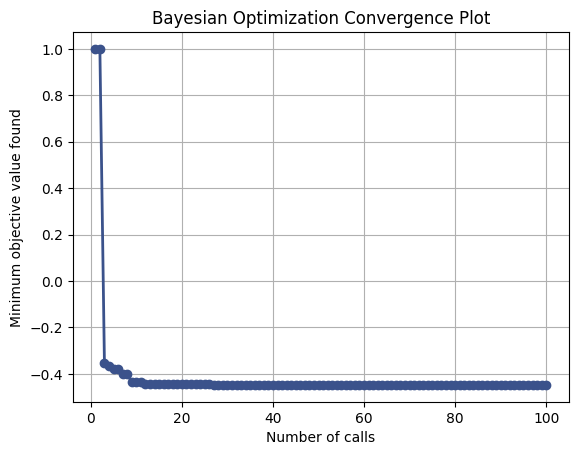

Đã vẽ biểu đồ hội tụ thành công.

--- Hoàn tất quá trình tối ưu hóa trọng số Implicit Feedback cho Hệ thống Lai ---


In [8]:
# Cell 4: Tối ưu hóa trọng số Implicit Feedback (Sử dụng Bayesian Optimization)

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
import matplotlib.pyplot as plt
import json
import datetime
import os # Đảm bảo import os cho os.makedirs và os.path.join


print("\n--- Bắt đầu quá trình tối ưu hóa trọng số Implicit Feedback cho Hệ thống Lai bằng Bayesian Optimization ---")

# --- CHUẨN BỊ DỮ LIỆU CONTENT-BASED (CHỈ TẢI MỘT LẦN) ---
print("\n--- Đang tải và xử lý dữ liệu thuộc tính sản phẩm cho Content-based Filtering ---")
df_product_features = load_product_features()

# Kiểm tra nếu df_product_features rỗng, log cảnh báo và có thể thoát
if df_product_features.empty:
    logger.error("Không thể tải dữ liệu thuộc tính sản phẩm. Content-based Filtering sẽ không hoạt động.")
    content_similarities_global = {} # Đặt rỗng để tránh lỗi
else:
    # initialize_global_tfidf_model(df_product_features)
    initialize_global_bert_model(df_product_features)
    if GLOBAL_BERT_MODEL is None or GLOBAL_PRODUCT_EMBEDDINGS is None:
        logger.error("Mô hình BERT hoặc embeddings không được khởi tạo thành công. Content-based Filtering sẽ không hoạt động.")
        content_similarities_global = {}
    content_similarities_global = compute_content_similarity(df_product_features, top_k=TOP_K)
    logger.info(f"Hoàn tất tính toán độ tương đồng Content-based cho {len(content_similarities_global)} sản phẩm.")
    if not content_similarities_global:
        logger.warning("Không có độ tương đồng Content-based được tính toán. Kiểm tra dữ liệu và TF-IDF.")

if 'df_train_raw' in locals() and not df_train_raw.empty:
    item_interaction_counts_global = df_train_raw['product_id'].value_counts().to_dict()
    logger.info(f"Đã tính toán số lượng tương tác cho {len(item_interaction_counts_global)} sản phẩm.")
else:
    logger.error("df_train_raw không tồn tại hoặc rỗng. Không thể tính item_interaction_counts_global.")
    item_interaction_counts_global = {} # Đặt rỗng để tránh lỗi


def evaluate_weights_for_similarity(
    df_train_raw: pd.DataFrame,
    df_eval_raw: pd.DataFrame,
    current_weights: Dict[str, float],
    hybrid_alpha: float, # Thêm tham số hybrid_alpha
    content_sims: Dict[int, List[Tuple[int, float]]], # Thêm tham số content_sims
    cold_start_threshold: int, # THÊM THAM SỐ NÀY
    item_interaction_counts: Dict[int, int], # THÊM THAM SỐ NÀY
    top_n_recommendations: int = TOP_N_RECOMMENDATIONS,
    frequency_decay_factor: float = 0.1,
    final_hybrid_threshold: float = 0.0,
) -> Dict[str, float]:
    """
    Đánh giá chất lượng gợi ý (NDCG, Precision, Recall, MAP)
    cho một tập hợp trọng số phản hồi ngầm và trọng số lai (alpha) đã cho,
    sử dụng cả Collaborative Filtering và Content-based Filtering.
    """
    logger.debug(f"Đánh giá với trọng số: {current_weights}, alpha lai: {hybrid_alpha}, cold_start_threshold: {cold_start_threshold}")

  
    df_train_weighted = assign_implicit_feedback_scores(
        df_train_raw.copy(),
        current_weights,
        # max_frequency_cap=5, 
        frequency_decay_factor=frequency_decay_factor,
    )


    df_positive_scores = df_train_weighted[df_train_weighted['implicit_score'] > 0]
    logger.info(f"DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: {len(df_positive_scores)}")
    logger.info(f"DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: {df_positive_scores['user_id'].nunique()}")
    logger.info(f"DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: {df_positive_scores['product_id'].nunique()}")

    if df_train_weighted.empty or df_train_weighted['implicit_score'].sum() == 0:
        logger.warning("Không có dữ liệu huấn luyện có trọng số ý nghĩa cho CF. Trả về các số liệu bằng không.")
        return {'precision_at_n': 0.0, 'recall_at_n': 0.0, 'ndcg_at_n': 0.0, 'map': 0.0}
    logger.info(f"DF_TRAIN_WEIGHTED cho CF: {len(df_train_weighted)} dòng, min_score={df_train_weighted['implicit_score'].min():.2f}, max_score={df_train_weighted['implicit_score'].max():.2f}")

    collab_similarities = compute_sparse_similarity(
        df_train_weighted, top_k=TOP_K, threshold=COSINE_THRESHOLD
    )
    logger.info(f"Số lượng item có độ tương đồng CF: {len(collab_similarities)}")
    
    
    
    # --- 2. Kết hợp độ tương đồng CF và Content-based ---
    if not collab_similarities and not content_sims:
        logger.warning("Không có độ tương đồng CF hoặc Content-based. Không thể tạo gợi ý lai. Trả về các số liệu bằng không.")
        return {'precision_at_n': 0.0, 'recall_at_n': 0.0, 'ndcg_at_n': 0.0, 'map': 0.0}

    # Đảm bảo hàm combine_similarities có thể xử lý khi một trong hai dict rỗng
    # Hàm combine_similarities sẽ tự động bỏ qua các trường hợp không có dữ liệu
    hybrid_similarities = combine_similarities(
        collab_similarities,
        content_sims,
        hybrid_alpha, # alpha_base
        item_interaction_counts, # THÊM
        cold_start_threshold, # THÊM
        top_k=TOP_K
    )
    logger.info(f"Số lượng item có độ tương đồng lai: {len(hybrid_similarities)}")

     # <--- THÊM LOGIC LỌC FINAL_HYBRID_THRESHOLD TẠI ĐÂY ---
    if final_hybrid_threshold > 0: # Chỉ lọc nếu ngưỡng > 0
        filtered_hybrid_similarities = {}
        count_filtered_pairs = 0
        for p1, neighbours in hybrid_similarities.items():
            filtered_neighbours_for_p1 = []
            for p2, hybrid_score, cf_score, content_score in neighbours:
                if hybrid_score >= final_hybrid_threshold:
                    filtered_neighbours_for_p1.append((p2, hybrid_score, cf_score, content_score))
            if filtered_neighbours_for_p1:
                filtered_hybrid_similarities[p1] = filtered_neighbours_for_p1
            else: # Đảm bảo item vẫn có entry dù rỗng nếu không tìm được láng giềng
                filtered_hybrid_similarities[p1] = []
        hybrid_similarities = filtered_hybrid_similarities
        logger.info(f"Số lượng item có độ tương đồng lai (sau khi lọc final_hybrid_threshold): {len(hybrid_similarities)}")
    # --- KẾT THÚC LOGIC LỌC ---
    
    if not hybrid_similarities:
        logger.warning("Ma trận độ tương đồng lai rỗng. Trả về các số liệu bằng không.")
        return {'precision_at_n': 0.0, 'recall_at_n': 0.0, 'ndcg_at_n': 0.0, 'map': 0.0}

    # --- 3. Đánh giá hệ thống gợi ý lai ---
    user_train_purchases_map = df_train_raw[df_train_raw['event_type'] == 'purchase'] \
                                 .groupby('user_id')['product_id'].apply(set).to_dict()

    user_eval_actual_interactions = df_eval_raw.groupby('user_id')['product_id'].apply(set).to_dict()

    users_to_evaluate = [u for u in user_eval_actual_interactions.keys() if u in user_train_purchases_map]

    precisions, recalls, ndcgs, maps = [], [], [], []
    logger.info(f"Số lượng người dùng đủ điều kiện để đánh giá: {len(users_to_evaluate)}")

    for user_id in users_to_evaluate:
        train_purchased_items = user_train_purchases_map.get(user_id, set())
        actual_items = user_eval_actual_interactions.get(user_id, set())

        if not train_purchased_items or not actual_items:
            continue

        scores: Dict[int, float] = defaultdict(float)

        # Aggregate scores from hybrid similar items
        for p in train_purchased_items:
            # Lấy hybrid_score từ tuple trả về của combine_similarities
            for q, hybrid_score, cf_score, content_score in hybrid_similarities.get(p, []):
                if q not in train_purchased_items:
                    scores[q] += float(hybrid_score)

        recommended_items_list = [item for item, score in sorted(scores.items(), key=lambda x: x[1], reverse=True)][:top_n_recommendations]

        if recommended_items_list and actual_items:
            precisions.append(precision_at_n(recommended_items_list, actual_items, top_n_recommendations))
            recalls.append(recall_at_n(recommended_items_list, actual_items, top_n_recommendations))
            ndcgs.append(ndcg_at_n(recommended_items_list, actual_items, top_n_recommendations))
            maps.append(average_precision(recommended_items_list, actual_items))

    avg_precision = np.mean(precisions) if precisions else 0.0
    avg_recall = np.mean(recalls) if recalls else 0.0
    avg_ndcg = np.mean(ndcgs) if ndcgs else 0.0
    avg_map = np.mean(maps) if maps else 0.0

    logger.debug(f"Kết quả đánh giá: P@{top_n_recommendations}: {avg_precision:.4f}, R@{top_n_recommendations}: {avg_recall:.4f}, NDCG@{top_n_recommendations}: {avg_ndcg:.4f}, MAP: {avg_map:.4f}")

    return {
        'precision_at_n': avg_precision,
        'recall_at_n': avg_recall,
        'ndcg_at_n': avg_ndcg,
        'map': avg_map
    }


def compute_sparse_similarity(
    df: pd.DataFrame,
    top_k: int = TOP_K,
    threshold: float = COSINE_THRESHOLD
) -> Dict[int, List[Tuple[int, float]]]:
    """
    Tính toán độ tương đồng item-item cosine từ DataFrame với điểm phản hồi ngầm,
    trả về một từ điển chứa top-k item tương đồng cho mỗi item.
    """
    logger.info("Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...")

    if 'implicit_score' not in df.columns:
        raise ValueError("DataFrame phải chứa cột 'implicit_score'.")

    df_filtered = df[df['implicit_score'] > 0].copy()

    logger.info(f"DEBUG_SIM: Kích thước DataFrame đã lọc (implicit_score > 0): {len(df_filtered)} dòng")
    if df_filtered.empty:
        logger.warning("Không tìm thấy điểm ngầm dương nào để tính độ tương đồng. Trả về từ điển rỗng.")
        return {}

    active_users = df_filtered['user_id'].unique()
    active_items = df_filtered['product_id'].unique()
    logger.info(f"DEBUG_SIM: Số lượng người dùng hoạt động duy nhất sau khi lọc: {len(active_users)}")
    logger.info(f"DEBUG_SIM: Số lượng item hoạt động duy nhất sau khi lọc: {len(active_items)}")

    user_to_idx = {u: i for i, u in enumerate(active_users)}
    item_to_idx = {p: i for i, p in enumerate(active_items)}
    idx_to_item = {i: p for p, i in item_to_idx.items()}

    rows = df_filtered['user_id'].map(user_to_idx)
    cols = df_filtered['product_id'].map(item_to_idx)
    data = df_filtered['implicit_score'].astype(float).to_numpy()

    logger.info(f"DEBUG_SIM: Kích thước của rows: {len(rows)}, cols: {len(cols)}, data: {len(data)}")

    if len(active_users) == 0 or len(active_items) == 0:
        logger.warning("Không đủ người dùng hoặc item duy nhất có điểm ngầm dương để tính toán độ tương đồng. Trả về từ điển rỗng.")
        return {}

    sparse_ui = csr_matrix((data, (rows, cols)), shape=(len(active_users), len(active_items)))
    logger.info(f"DEBUG_SIM: Hình dạng ma trận User-Item thưa thớt: {sparse_ui.shape}, số lượng phần tử khác không (nnz): {sparse_ui.nnz}")

    sim_matrix = cosine_similarity(sparse_ui.T, dense_output=False)
    logger.info(f"DEBUG_SIM: Hình dạng ma trận độ tương đồng Item-Item thưa thớt: {sim_matrix.shape}, số lượng phần tử khác không (nnz): {sim_matrix.nnz}")

    item_similarities: Dict[int, List[Tuple[int, float]]] = {}
    count_items_with_any_similarity_after_threshold = 0

    for i, item_idx_i in enumerate(active_items):
        original_product_id = item_idx_i
        row = sim_matrix.getrow(i)

        if row.nnz:
            idxs = row.indices
            vals = row.data

            filtered_similarities = [
                (j_idx, s) for j_idx, s in zip(idxs, vals)
                if j_idx != i and s >= threshold
            ]

            if filtered_similarities:
                count_items_with_any_similarity_after_threshold += 1
                topk_pairs = sorted(filtered_similarities, key=lambda x: x[1], reverse=True)[:top_k]
                item_similarities[original_product_id] = [(idx_to_item[j_idx], float(s)) for j_idx, s in topk_pairs]
            else:
                item_similarities[original_product_id] = []
        else:
            item_similarities[original_product_id] = []

    logger.info(f"DEBUG_SIM: Tổng số item (original_product_id) có ít nhất MỘT độ tương đồng HỢP LỆ (khác nó và >= ngưỡng): {count_items_with_any_similarity_after_threshold}")
    logger.info("Hoàn tất tính toán độ tương đồng thưa thớt.")
    return item_similarities


# Định nghĩa không gian tìm kiếm cho Bayesian Optimization
# Bây giờ bao gồm cả HYBRID_ALPHA và cold_start_threshold
space = [
    Real(0.1, 0.2, name='view'),
    Real(0.2, 0.7, name='add_to_cart'),
    Real(0.1, 0.4, name='wishlist'),
    Real(0.0, 1.0, name='hybrid_alpha'),
    Integer(1, 20, name='cold_start_threshold'),
    Real(0.01, 0.5, name='frequency_decay_factor'),
    Real(0.0, 0.5, name='final_hybrid_threshold'), # <--- THÊM DÒNG NÀY

]

# Định nghĩa trọng số purchase cố định
FIXED_PURCHASE_WEIGHT = 1.0

@use_named_args(space)
def objective(view, add_to_cart, wishlist, hybrid_alpha, cold_start_threshold,frequency_decay_factor,final_hybrid_threshold): # CẬP NHẬT ĐỐI SỐ
    current_weights = {
        'view': view,
        'add_to_cart': add_to_cart,
        'wishlist': wishlist,
        'purchase': FIXED_PURCHASE_WEIGHT # Sử dụng giá trị cố định ở đây
    }

    # Kiểm tra ràng buộc thứ tự cho trọng số phản hồi ngầm
    epsilon = 1e-6
    if not (current_weights['view'] < current_weights['wishlist'] - epsilon and
            current_weights['wishlist'] < current_weights['add_to_cart'] - epsilon and
            current_weights['add_to_cart'] < current_weights['purchase'] - epsilon):
        logger.warning(f"DEBUG_OBJ: Vi phạm ràng buộc thứ tự với trọng số ngầm: {current_weights}. Trả về 1.0.")
        return 1.0 # Giá trị cao, nghĩa là tệ, để Bayesian Opt không chọn

    # Kiểm tra ràng buộc cho hybrid_alpha
    if not (0.0 <= hybrid_alpha <= 1.0):
        logger.warning(f"DEBUG_OBJ: hybrid_alpha ({hybrid_alpha}) nằm ngoài khoảng [0, 1]. Trả về 1.0.")
        return 1.0

    # Kiểm tra ràng buộc cho cold_start_threshold (nếu cần, nhưng Integer(1,20) đã xử lý)
    if not (1 <= cold_start_threshold <= 20):
        logger.warning(f"DEBUG_OBJ: cold_start_threshold ({cold_start_threshold}) nằm ngoài khoảng [1, 20]. Trả về 1.0.")
        return 1.0

    logger.info(f"DEBUG_OBJ: Đánh giá với trọng số: {current_weights}, alpha lai: {hybrid_alpha}, cold_start_threshold: {cold_start_threshold}")

    evaluation_metrics = evaluate_weights_for_similarity(
        df_train_raw.copy(),
        df_val_raw.copy(),
        current_weights,
        hybrid_alpha, # Truyền hybrid_alpha vào hàm đánh giá
        content_similarities_global, # Truyền content_similarities đã tính toán một lần
        cold_start_threshold, # TRUYỀN THAM SỐ MỚI VÀO
        item_interaction_counts_global, # TRUYỀN THAM SỐ MỚI VÀO
        TOP_N_RECOMMENDATIONS,
        frequency_decay_factor,
        final_hybrid_threshold=final_hybrid_threshold,
    )

    score_to_minimize = -evaluation_metrics['ndcg_at_n']
    logger.info(f"DEBUG_OBJ: NDCG@{TOP_N_RECOMMENDATIONS}: {evaluation_metrics['ndcg_at_n']:.4f}, Optimization Score: {score_to_minimize:.4f}")
    return score_to_minimize

# Thực hiện tối ưu hóa Bayesian nếu dữ liệu đủ
if not df_raw_events.empty and 'common_users_for_eval' in locals() and len(common_users_for_eval) > 0:
    logger.info("Bắt đầu tối ưu hóa Bayesian...")
    result = gp_minimize(
        objective,
        space,
        n_calls=100,
        n_random_starts=20,
        random_state=42,
        verbose=True
    )

    # Trích xuất trọng số tối ưu
    # Các chỉ số của result.x sẽ tương ứng với thứ tự trong 'space'
    optimal_weights = {
        'view': result.x[0],
        'add_to_cart': result.x[1],
        'wishlist': result.x[2],
        'purchase': FIXED_PURCHASE_WEIGHT # Thêm lại trọng số purchase cố định vào kết quả
    }
    optimal_hybrid_alpha = result.x[3]
    optimal_cold_start_threshold = int(result.x[4]) # Lấy cold_start_threshold và chuyển sang int
    optimal_frequency_decay_factor = result.x[5] # <-- TRÍCH XUẤT THAM SỐ MỚI VÀO ĐÂY
    optimal_final_hybrid_threshold = result.x[6] # <--- TRÍCH XUẤT THAM SỐ MỚI

    best_ndcg = -result.fun # result.fun là giá trị tối thiểu của hàm mục tiêu (-NDCG)
    print(f"\n--- Trọng số tối ưu tìm được bằng Bayesian Optimization trên tập Validation: {optimal_weights} ---")
    print(f"--- Alpha lai tối ưu: {optimal_hybrid_alpha:.4f} ---")
    print(f"--- Ngưỡng Cold-Start tối ưu: {optimal_cold_start_threshold} ---") # In ra ngưỡng cold-start
    print(f"--- Frequency Decay Factor tối ưu: {optimal_frequency_decay_factor:.4f} ---") # <-- IN RA
    print(f"--- Ngưỡng Lai Cuối Cùng tối ưu: {optimal_final_hybrid_threshold:.4f} ---") # <--- IN RA
    print(f"--- Với điểm NDCG tốt nhất: {best_ndcg:.4f} ---")


    # --- THÊM PHẦN LƯU TRỮ TRỌNG SỐ VÀO TỆP JSON TẠY ĐÂY ---
    results_dir = 'optimization_results'
    os.makedirs(results_dir, exist_ok=True) # Đảm bảo thư mục tồn tại

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    weights_file_name = os.path.join(results_dir, f'optimal_hybrid_weights_{timestamp}.json')

    try:
        with open(weights_file_name, 'w') as f:
            json.dump({
                "optimal_implicit_weights": optimal_weights,
                "optimal_hybrid_alpha": optimal_hybrid_alpha,
                "optimal_cold_start_threshold": int(optimal_cold_start_threshold), # Lưu int
                "optimal_frequency_decay_factor": optimal_frequency_decay_factor, # <--- LƯU THAM SỐ MỚI
                "optimal_final_hybrid_threshold": optimal_final_hybrid_threshold, # <--- LƯU THAM SỐ MỚI
                "best_ndcg": best_ndcg,
                "top_n_recommendations": TOP_N_RECOMMENDATIONS,
                "top_k_similar_items": TOP_K,
                "cosine_threshold": COSINE_THRESHOLD,
                "optimization_timestamp": timestamp
            }, f, indent=4)
        print(f"\n--- Trọng số lai tối ưu đã được lưu vào: {weights_file_name} ---")
    except Exception as e:
        print(f"\n--- Lỗi khi lưu trọng số vào tệp JSON: {e} ---")
    # --- KẾT THÚC PHẦN LƯU TRỮ ---
     # print(f"\n--- Đang vẽ biểu đồ hội tụ ---")
    try:
        plot_convergence(result)
        plt.title('Bayesian Optimization Convergence Plot')
        plt.xlabel('Number of calls')
        plt.ylabel('Minimum objective value found')
        plt.grid(True)
        plt.show()
        print("Đã vẽ biểu đồ hội tụ thành công.")
    except Exception as e:
        print(f"Lỗi khi vẽ biểu đồ hội tụ: {e}")




else:
    logger.warning("Bỏ qua Tối ưu hóa Bayesian do không đủ dữ liệu để đánh giá (ví dụ: không có người dùng chung để đánh giá).")

print("\n--- Hoàn tất quá trình tối ưu hóa trọng số Implicit Feedback cho Hệ thống Lai ---")

2025-07-25 10:04:58,117 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:04:58,138 - INFO - DEBUG_EVAL: Số lượng dòng có implicit_score > 0 trong df_train_weighted: 103975
2025-07-25 10:04:58,140 - INFO - DEBUG_EVAL: Số lượng người dùng duy nhất có implicit_score > 0 trong df_train_weighted: 2000
2025-07-25 10:04:58,142 - INFO - DEBUG_EVAL: Số lượng sản phẩm duy nhất có implicit_score > 0 trong df_positive_scores: 18
2025-07-25 10:04:58,143 - INFO - DF_TRAIN_WEIGHTED cho CF: 115120 dòng, min_score=0.00, max_score=1.00
2025-07-25 10:04:58,145 - INFO - Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...
2025-07-25 10:04:58,149 - INFO - DEBUG_SIM: Kích thước DataFrame đã lọc (implicit_score > 0): 103975 dòng
2025-07-25 10:04:58,149 - INFO - DEBUG_SIM: Số lượng người dùng hoạt động duy nhất sau khi lọc: 2000
2025-07-25 10:04:58,149 - INFO - DEBUG_SIM: Số lượng item hoạt động duy nhất sau


--- Bắt đầu đánh giá hiệu suất cuối cùng trên tập Test độc lập ---


2025-07-25 10:04:58,183 - INFO - DEBUGGING ALPHA: For p1=69 (Interactions: 3986), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,183 - INFO - DEBUGGING ALPHA: For p1=70 (Interactions: 912), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,184 - INFO - DEBUGGING ALPHA: For p1=71 (Interactions: 7293), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,184 - INFO - DEBUGGING ALPHA: For p1=72 (Interactions: 7678), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,185 - INFO - DEBUGGING ALPHA: For p1=73 (Interactions: 4181), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,186 - INFO - DEBUGGING ALPHA: For p1=74 (Interactions: 0), cold_start_threshold=15, dynamic_alpha used: 0.1000
2025-07-25 10:04:58,186 - INFO - DEBUGGING ALPHA: For p1=56 (Interactions: 23848), cold_start_threshold=15, dynamic_alpha used: 0.8851
2025-07-25 10:04:58,187 - INFO - DEBUGGING ALPHA: For p1=57 (Inte


--- Hiệu suất mô hình cuối cùng trên tập Test Set với TOP_N=15 ---
- precision_at_n: 0.3071
- recall_at_n: 0.5407
- ndcg_at_n: 0.4637
- map: 0.2926


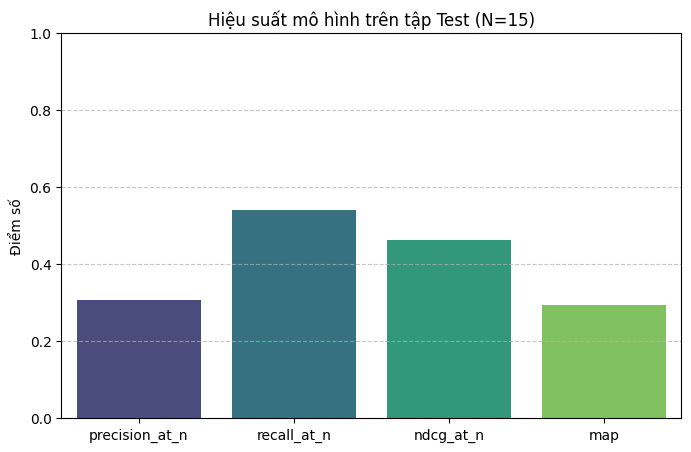


--- Hoàn tất đánh giá hiệu suất cuối cùng trên tập Test độc lập ---


In [9]:
# Cell 5: Đánh giá hiệu suất cuối cùng trên Test Set

print("\n--- Bắt đầu đánh giá hiệu suất cuối cùng trên tập Test độc lập ---")
# Đảm bảo df_train_raw và df_test_raw được giữ nguyên từ Cell 3
final_evaluation_metrics = evaluate_weights_for_similarity(
    df_train_raw.copy(),
    df_test_raw.copy(),
    optimal_weights,
    optimal_hybrid_alpha,
    # SỬA LỖI Ở ĐÂY: Đổi thứ tự tham số để khớp với định nghĩa hàm
    content_similarities_global, # content_sims là tham số thứ 5 trong định nghĩa
    optimal_cold_start_threshold, # cold_start_threshold là tham số thứ 6 trong định nghĩa
    # Bạn cũng cần truyền item_interaction_counts_global vào đây
    item_interaction_counts_global, # Thêm tham số này vào lời gọi hàm
    TOP_N_RECOMMENDATIONS,
    optimal_frequency_decay_factor 
)
print(f"\n--- Hiệu suất mô hình cuối cùng trên tập Test Set với TOP_N={TOP_N_RECOMMENDATIONS} ---")
for metric, score in final_evaluation_metrics.items():
    print(f"- {metric}: {score:.4f}")

# Trực quan hóa kết quả đánh giá cuối cùng
metrics_names = list(final_evaluation_metrics.keys())
metrics_values = list(final_evaluation_metrics.values())

plt.figure(figsize=(8, 5))
# Đảm bảo sns đã được import: import seaborn as sns
import seaborn as sns # Thêm dòng này nếu chưa có ở Cell 1
sns.barplot(x=metrics_names, y=metrics_values, palette='viridis')
plt.title(f'Hiệu suất mô hình trên tập Test (N={TOP_N_RECOMMENDATIONS})')
plt.ylabel('Điểm số')
plt.ylim(0, 1) # Đảm bảo trục Y từ 0 đến 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Hoàn tất đánh giá hiệu suất cuối cùng trên tập Test độc lập ---")

2025-07-25 10:08:02,971 - INFO - Assigned implicit scores considering frequency with log transform. Min score: 0.0000, Max score: 1.0000
2025-07-25 10:08:02,978 - INFO - Tổng số sự kiện sau khi gán trọng số: 193204
2025-07-25 10:08:02,989 - INFO - Số lượng sự kiện có implicit_score > 0: 172479



--- Bắt đầu quá trình tính toán và lưu trữ Hybrid Item Similarity ---

--- Áp dụng trọng số tối ưu cho toàn bộ dữ liệu sự kiện ---

--- DEBUG: Kiểm tra Event Types và Weights ---
Unique event_types in df_raw_events: ['view' 'add_to_cart' 'purchase' 'wishlist' 'rate']
Keys in optimal_weights: dict_keys(['view', 'add_to_cart', 'wishlist', 'purchase'])

--- DEBUG: Tham số đang được truyền vào assign_implicit_feedback_scores ---
Optimal Weights: {'view': 0.17056806038472655, 'add_to_cart': 0.4758852868806091, 'wishlist': 0.3607027193434893, 'purchase': 1.0}
Optimal Frequency Decay Factor (from optimal_frequency_decay_factor): 0.3464690062
Kiểu dữ liệu của optimal_frequency_decay_factor: <class 'float'>
Kiểu dữ liệu của optimal_weights['view']: <class 'float'>
--- 5 hàng đầu tiên của dữ liệu sự kiện đã gán trọng số (Toàn bộ dữ liệu) ---
   user_id  product_id   event_type          created_at  implicit_score
0      164          56         view 2025-02-16 18:56:50        0.212953
1      164 

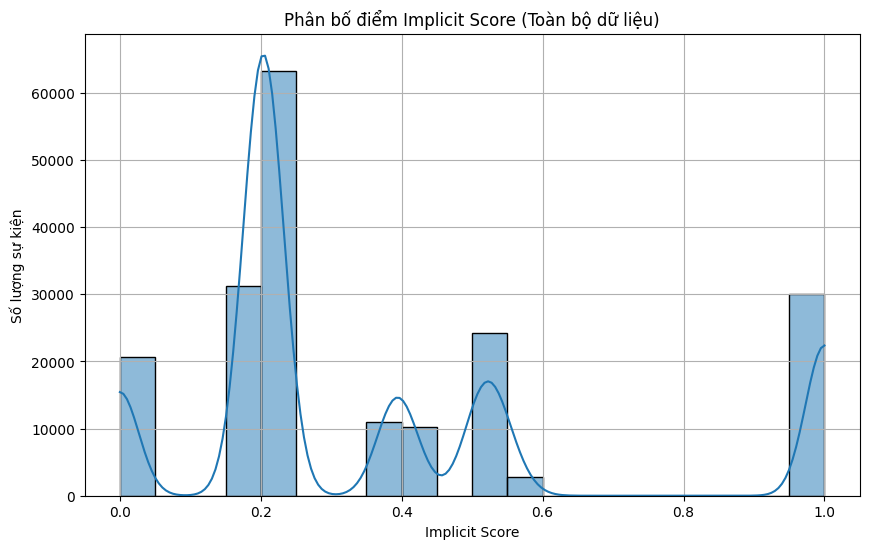

2025-07-25 10:08:04,084 - INFO - Đã tính số lượng tương tác cho 18 sản phẩm.
2025-07-25 10:08:04,084 - INFO - Đang tính toán ma trận độ tương đồng item-item thưa thớt sử dụng điểm ngầm...
2025-07-25 10:08:04,103 - INFO - DEBUG_SIM: Kích thước DataFrame đã lọc (implicit_score > 0): 172479 dòng
2025-07-25 10:08:04,109 - INFO - DEBUG_SIM: Số lượng người dùng hoạt động duy nhất sau khi lọc: 2000
2025-07-25 10:08:04,110 - INFO - DEBUG_SIM: Số lượng item hoạt động duy nhất sau khi lọc: 18
2025-07-25 10:08:04,112 - INFO - DEBUG_SIM: Kích thước của rows: 172479, cols: 172479, data: 172479
2025-07-25 10:08:04,124 - INFO - DEBUG_SIM: Hình dạng ma trận User-Item thưa thớt: (2000, 18), số lượng phần tử khác không (nnz): 27883
2025-07-25 10:08:04,127 - INFO - DEBUG_SIM: Hình dạng ma trận độ tương đồng Item-Item thưa thớt: (18, 18), số lượng phần tử khác không (nnz): 324
2025-07-25 10:08:04,127 - INFO - DEBUG_SIM: Tổng số item (original_product_id) có ít nhất MỘT độ tương đồng HỢP LỆ (khác nó và >= 


--- Tính toán số lượng tương tác của sản phẩm cho Dynamic Weighting ---

--- Bắt đầu tính toán độ tương đồng Collaborative Filtering (CF) từ toàn bộ dữ liệu ---

--- Bắt đầu kết hợp độ tương đồng CF và Content-based (Hybrid) ---

--- Đang lọc Hybrid Item Similarity bằng FINAL_HYBRID_THRESHOLD (0.1392) ---

--- 5 ví dụ đầu tiên về Hybrid Item Similarity (Product ID: [List of (Similar Product ID, Hybrid Score, CF Score, Content Score)]) ---
Product ID 64: [(np.int64(56), 0.6935575030092427, 0.6640699948931837, 0.920799732208252), (np.int64(67), 0.608358448221916, 0.5620575958941143, 0.9651708602905273), (np.int64(66), 0.5845062080883249, 0.5373344945344601, 0.9480298161506653), (np.int64(58), 0.5508498542219143, 0.5050134544963575, 0.9040830135345459), (np.int64(73), 0.5471921452533111, 0.49873853186391215, 0.9205945730209351), (np.int64(61), 0.5428522909442808, 0.4916785145675364, 0.9372173547744751), (np.int64(59), 0.4992201754050395, 0.5640002078217462, 0.0), (np.int64(60), 0.4971314

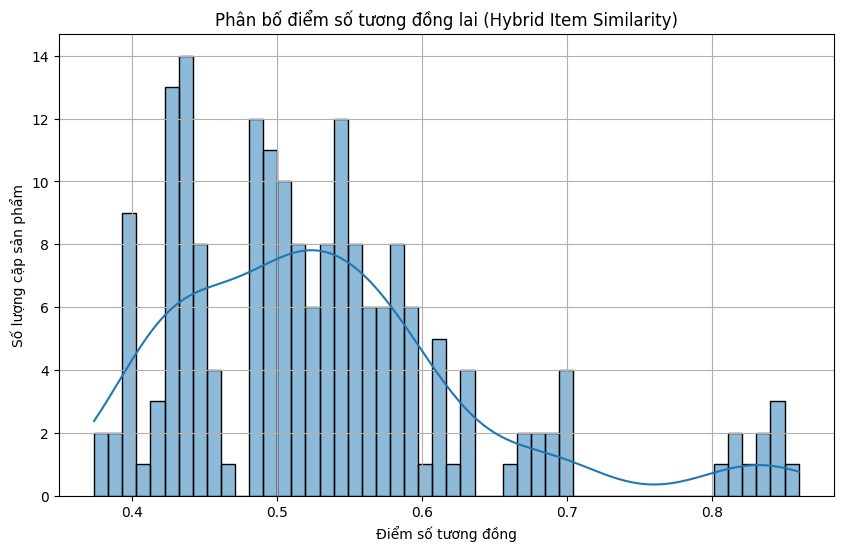

2025-07-25 10:08:04,355 - INFO - Cleared existing data from item_similarity.
2025-07-25 10:08:04,370 - INFO - Persisted 132 unique item similarities successfully into item_similarity.



--- Bắt đầu lưu trữ độ tương đồng Hybrid Item Similarity vào cơ sở dữ liệu ---
--- Hoàn tất lưu trữ Hybrid Item Similarity ---

--- Hoàn tất quá trình tính toán và lưu trữ Hybrid Item Similarity ---


In [10]:
# Cell 6: Tính toán và lưu trữ Hybrid Item Similarity (Sử dụng toàn bộ dữ liệu)

print("\n--- Bắt đầu quá trình tính toán và lưu trữ Hybrid Item Similarity ---")

# 1. Tải và xử lý dữ liệu thuộc tính sản phẩm cho Content-based Filtering
# (Bước này thực tế đã được chạy trong Cell 4 và content_similarities_global đã có)
# Tuy nhiên, để đảm bảo tính độc lập hoặc nếu chạy riêng Cell 6, bạn có thể chạy lại.
# Nếu content_similarities_global đã được định nghĩa từ Cell 4, có thể bỏ qua dòng này.
# Để an toàn, chúng ta sẽ kiểm tra và tải lại nếu cần.
if 'content_similarities_global' not in locals() or not content_similarities_global:
    print("\n--- Đang tải và xử lý dữ liệu thuộc tính sản phẩm cho Content-based Filtering (nếu chưa có) ---")
    df_product_features = load_product_features()
    if df_product_features.empty:
        logger.error("Không thể tải dữ liệu thuộc tính sản phẩm. Content-based Filtering sẽ không hoạt động.")
        content_similarities_global = {} # Đặt rỗng để tránh lỗi
    else:
        content_similarities_global = compute_content_similarity(df_product_features, top_k=TOP_K)
        logger.info(f"Hoàn tất tính toán độ tương đồng Content-based cho {len(content_similarities_global)} sản phẩm.")
        if not content_similarities_global:
            logger.warning("Không có độ tương đồng Content-based được tính toán. Kiểm tra dữ liệu và TF-IDF.")


# 2. Áp dụng trọng số tối ưu cho toàn bộ dữ liệu sự kiện thô để có 'implicit_score'
print("\n--- Áp dụng trọng số tối ưu cho toàn bộ dữ liệu sự kiện ---")
# Đảm bảo df_raw_events và optimal_weights đã được định nghĩa từ các cell trước.
# optimal_weights được lấy từ Cell 4.
if 'optimal_weights' not in locals():
    logger.error("optimal_weights chưa được định nghĩa. Hãy chạy Cell 4 trước.")
    raise NameError("optimal_weights is not defined. Please run Cell 4.")


# Trong Cell 6, trước dòng gọi assign_implicit_feedback_scores:
print(f"\n--- DEBUG: Kiểm tra Event Types và Weights ---")
if 'df_raw_events' in globals(): # Kiểm tra xem biến có tồn tại không
    print("Unique event_types in df_raw_events:", df_raw_events['event_type'].unique())
else:
    logger.warning("df_raw_events không tồn tại khi kiểm tra event types.")

if 'optimal_weights' in globals(): # Kiểm tra xem biến có tồn tại không
    print("Keys in optimal_weights:", optimal_weights.keys())
else:
    logger.warning("optimal_weights không tồn tại khi kiểm tra event types.")


df_weighted_events_for_final_model = assign_implicit_feedback_scores(df_raw_events.copy(), optimal_weights)
logger.info(f"Tổng số sự kiện sau khi gán trọng số: {len(df_weighted_events_for_final_model)}")
logger.info(f"Số lượng sự kiện có implicit_score > 0: {len(df_weighted_events_for_final_model[df_weighted_events_for_final_model['implicit_score'] > 0])}")
print(f"\n--- DEBUG: Tham số đang được truyền vào assign_implicit_feedback_scores ---")
print(f"Optimal Weights: {optimal_weights}")
print(f"Optimal Frequency Decay Factor (from optimal_frequency_decay_factor): {optimal_frequency_decay_factor:.10f}") # In với độ chính xác cao
print(f"Kiểu dữ liệu của optimal_frequency_decay_factor: {type(optimal_frequency_decay_factor)}")
print(f"Kiểu dữ liệu của optimal_weights['view']: {type(optimal_weights['view'])}")

print("--- 5 hàng đầu tiên của dữ liệu sự kiện đã gán trọng số (Toàn bộ dữ liệu) ---")
print(df_weighted_events_for_final_model.head())

print("\n--- Kiểm tra giá trị implicit_score thực tế cho các hàng 'view' bị hiển thị là 0 ---")
# Lấy ra các hàng có event_type là 'view' và implicit_score hiển thị là 0
# (Lưu ý: chúng ta kiểm tra giá trị thực, không phải giá trị hiển thị)
df_views_with_low_score = df_weighted_events_for_final_model[
    (df_weighted_events_for_final_model['event_type'] == 'view') &
    (df_weighted_events_for_final_model['implicit_score'] < 0.001) # Kiểm tra các giá trị rất nhỏ
].head(10) # Lấy 10 hàng đầu tiên để kiểm tra

if not df_views_with_low_score.empty:
    with pd.option_context('display.float_format', '{:.10f}'.format): # Hiển thị nhiều chữ số thập phân hơn
        print(df_views_with_low_score[['user_id', 'product_id', 'event_type', 'implicit_score']])
else:
    print("Không tìm thấy hàng 'view' nào có implicit_score gần bằng 0.")

print(f"\nGiá trị nhỏ nhất của implicit_score trong toàn bộ DataFrame: {df_weighted_events_for_final_model['implicit_score'].min():.10f}")


# Trực quan hóa phân bố điểm implicit_score
plt.figure(figsize=(10, 6))
sns.histplot(df_weighted_events_for_final_model['implicit_score'], bins=20, kde=True)
plt.title('Phân bố điểm Implicit Score (Toàn bộ dữ liệu)')
plt.xlabel('Implicit Score')
plt.ylabel('Số lượng sự kiện')
plt.grid(True)
plt.show()


print("\n--- Tính toán số lượng tương tác của sản phẩm cho Dynamic Weighting ---")
# Sử dụng df_raw_events để lấy số lượng tương tác thô của từng sản phẩm.
# Đây là dữ liệu gốc, chưa bị loại bỏ hay biến đổi.
if 'df_raw_events' not in locals():
    logger.error("df_raw_events chưa được định nghĩa. Hãy tải dữ liệu gốc trước.")
    raise NameError("df_raw_events is not defined. Please ensure raw event data is loaded.")
item_interaction_counts_for_final_model = df_raw_events['product_id'].value_counts().to_dict()
logger.info(f"Đã tính số lượng tương tác cho {len(item_interaction_counts_for_final_model)} sản phẩm.")

# 3. Tính toán độ tương đồng Collaborative Filtering từ toàn bộ dữ liệu
print("\n--- Bắt đầu tính toán độ tương đồng Collaborative Filtering (CF) từ toàn bộ dữ liệu ---")
collab_similarities_final = compute_sparse_similarity(df_weighted_events_for_final_model, TOP_K, COSINE_THRESHOLD)
logger.info(f"Đã tính toán độ tương đồng CF cho {len(collab_similarities_final)} sản phẩm.")

# 4. Kết hợp độ tương đồng CF và Content-based sử dụng alpha lai tối ưu
print("\n--- Bắt đầu kết hợp độ tương đồng CF và Content-based (Hybrid) ---")
# Đảm bảo optimal_hybrid_alpha đã được định nghĩa từ Cell 4.
if 'optimal_hybrid_alpha' not in locals():
    logger.error("optimal_hybrid_alpha chưa được định nghĩa. Hãy chạy Cell 4 trước.")
    raise NameError("optimal_hybrid_alpha is not defined. Please run Cell 4.")

final_hybrid_similarities = combine_similarities(
    collab_similarities_final,
    content_similarities_global,
    optimal_hybrid_alpha, # Sử dụng alpha lai tối ưu
    item_interaction_counts_for_final_model, # TRUYỀN THAM SỐ MỚI ĐÃ TÍNH
    int(optimal_cold_start_threshold),
    top_k=TOP_K
)


# print("\n--- Bắt đầu kết hợp độ tương đồng CF và Content-based (Hybrid) ---")
# # Đảm bảo optimal_hybrid_alpha đã được định nghĩa từ Cell 4.
# if 'HYBRID_ALPHA' not in locals():
#     logger.error("optimal_hybrid_alpha chưa được định nghĩa. Hãy chạy Cell 4 trước.")
#     raise NameError("optimal_hybrid_alpha is not defined. Please run Cell 4.")

# final_hybrid_similarities = combine_similarities(
#     collab_similarities_final,
#     content_similarities_global,
#     HYBRID_ALPHA, # Sử dụng alpha lai tối ưu
#     top_k=TOP_K
# )
logger.info(f"Đã tính toán độ tương đồng Hybrid cho {len(final_hybrid_similarities)} sản phẩm.")


# <--- BẮT ĐẦU THÊM LOGIC LỌC FINAL_HYBRID_THRESHOLD Ở ĐÂY ---
if optimal_final_hybrid_threshold > 0: # Chỉ lọc nếu ngưỡng > 0
    print(f"\n--- Đang lọc Hybrid Item Similarity bằng FINAL_HYBRID_THRESHOLD ({optimal_final_hybrid_threshold:.4f}) ---")
    filtered_final_hybrid_similarities = {}
    items_before_filter = len(final_hybrid_similarities)
    total_pairs_before_filter = sum(len(v) for v in final_hybrid_similarities.values())
    
    count_items_with_neighbors_after_filter = 0
    total_pairs_after_filter = 0

    for p1, neighbours in final_hybrid_similarities.items():
        filtered_neighbours_for_p1 = []
        for p2, hybrid_score, cf_score, content_score in neighbours:
            if hybrid_score >= optimal_final_hybrid_threshold:
                filtered_neighbours_for_p1.append((p2, hybrid_score, cf_score, content_score))
        
        if filtered_neighbours_for_p1:
            filtered_final_hybrid_similarities[p1] = filtered_neighbours_for_p1
            count_items_with_neighbors_after_filter += 1
            total_pairs_after_filter += len(filtered_neighbours_for_p1)
        # else: # Có thể giữ lại entry rỗng để biết sản phẩm đó vẫn được tính nhưng không có láng giềng phù hợp
        #     filtered_final_hybrid_similarities[p1] = [] 

    final_hybrid_similarities = filtered_final_hybrid_similarities # Cập nhật biến để sử dụng kết quả đã lọc
    logger.info(f"Số lượng sản phẩm có độ tương đồng Hybrid (sau khi lọc FINAL_HYBRID_THRESHOLD): {len(final_hybrid_similarities)}")
    logger.info(f"Tổng số cặp tương đồng trước lọc: {total_pairs_before_filter}, sau lọc: {total_pairs_after_filter}")
    logger.info(f"Số sản phẩm có láng giềng (trước lọc): {items_before_filter}, (sau lọc): {count_items_with_neighbors_after_filter}")

# --- KẾT THÚC LOGIC LỌC FINAL_HYBRID_THRESHOLD ---

# Kiểm tra nếu final_hybrid_similarities rỗng
if not final_hybrid_similarities:
    logger.warning("Ma trận độ tương đồng lai cuối cùng rỗng sau khi lọc. Không có dữ liệu để lưu trữ.")
else:
    # Hiển thị một vài ví dụ về độ tương đồng lai
    print("\n--- 5 ví dụ đầu tiên về Hybrid Item Similarity (Product ID: [List of (Similar Product ID, Hybrid Score, CF Score, Content Score)]) ---")
    count = 0
    for pid, sim_list in final_hybrid_similarities.items():
        print(f"Product ID {pid}: {sim_list}")
        count += 1
        if count >= 5:
            break

    # Trực quan hóa phân bố điểm số tương đồng lai (nếu có dữ liệu)
    all_hybrid_scores = []
    for pid, sim_list in final_hybrid_similarities.items():
        # SỬA LỖI Ở ĐÂY: bóc tách đủ 4 giá trị và sử dụng hybrid_score
        for _, hybrid_score, cf_score, content_score in sim_list:
            all_hybrid_scores.append(hybrid_score) # Dùng hybrid_score để trực quan hóa

    if all_hybrid_scores:
        plt.figure(figsize=(10, 6))
        sns.histplot(all_hybrid_scores, bins=50, kde=True)
        plt.title('Phân bố điểm số tương đồng lai (Hybrid Item Similarity)')
        plt.xlabel('Điểm số tương đồng')
        plt.ylabel('Số lượng cặp sản phẩm')
        plt.grid(True)
        plt.show()
    else:
        print("\nKhông có đủ dữ liệu độ tương đồng lai để vẽ biểu đồ.")


    # 5. Lưu trữ độ tương đồng lai vào cơ sở dữ liệu - SỬA ĐỔI QUAN TRỌNG
    def persist_similarity(topk: Dict[int, List[Tuple[int, float, float, float]]]):
        session = SessionLocal()
        try:
            session.execute(text(f"TRUNCATE TABLE {ItemSimilarity.__tablename__}"))
            session.commit()
            logger.info(f"Cleared existing data from {ItemSimilarity.__tablename__}.")
            batch = []
            row_count = 0
            # THÊM MỘT SET ĐỂ LƯU TRỮ CÁC CẶP ĐÃ ĐƯỢC THÊM
            processed_pairs = set()

            for p1, neighbours in topk.items():
                for p2, hybrid_score, cf_score, content_score in neighbours:
                    # Đảm bảo p1 luôn nhỏ hơn hoặc bằng p2 để tạo cặp duy nhất
                    # Sử dụng min/max để chuẩn hóa cặp
                    prod_id_1_normalized = min(int(p1), int(p2))
                    prod_id_2_normalized = max(int(p1), int(p2))

                    # Bỏ qua các cặp mà hai sản phẩm là như nhau (độ tương đồng của một item với chính nó)
                    if prod_id_1_normalized == prod_id_2_normalized:
                        continue

                    # Tạo một tuple đại diện cho cặp đã chuẩn hóa
                    current_pair = (prod_id_1_normalized, prod_id_2_normalized)

                    # Chỉ thêm vào batch nếu cặp này chưa được xử lý
                    if current_pair not in processed_pairs:
                        batch.append({
                            'product_id_1': prod_id_1_normalized,
                            'product_id_2': prod_id_2_normalized,
                            'score': float(hybrid_score),
                            'cf_score': float(cf_score),
                            'content_score': float(content_score)
                        })
                        processed_pairs.add(current_pair) # Thêm cặp đã xử lý vào set
                        row_count += 1

                    if len(batch) >= BATCH_SIZE:
                        try:
                            session.bulk_insert_mappings(ItemSimilarity, batch)
                            session.commit()
                            logger.debug(f"Inserted {len(batch)} rows into {ItemSimilarity.__tablename__}.")
                        except Exception as insert_e:
                            session.rollback()
                            logger.error(f"Lỗi khi bulk_insert_mappings: {insert_e}")
                            raise # Re-raise để dừng quá trình nếu lỗi nghiêm trọng
                        finally:
                            batch.clear()

            if batch: # Insert any remaining rows
                try:
                    session.bulk_insert_mappings(ItemSimilarity, batch)
                    session.commit()
                    logger.debug(f"Inserted {len(batch)} remaining rows into {ItemSimilarity.__tablename__}.")
                except Exception as insert_e:
                    session.rollback()
                    logger.error(f"Lỗi khi bulk_insert_mappings phần còn lại: {insert_e}")
                    raise # Re-raise để dừng quá trình nếu lỗi nghiêm trọng

            logger.info(f"Persisted {row_count} unique item similarities successfully into {ItemSimilarity.__tablename__}.")
        except Exception as e:
            session.rollback()
            logger.exception("Failed to persist item similarity: %s", e)
        finally:
            session.close()

    print("\n--- Bắt đầu lưu trữ độ tương đồng Hybrid Item Similarity vào cơ sở dữ liệu ---")
    # Đảm bảo `final_hybrid_similarities` đã được tính toán ở bước 4 của cell này
    persist_similarity(final_hybrid_similarities)
    print("--- Hoàn tất lưu trữ Hybrid Item Similarity ---")

print("\n--- Hoàn tất quá trình tính toán và lưu trữ Hybrid Item Similarity ---")

In [11]:
# Cell 7: Tạo và lưu trữ Recommendations cho người dùng
import pandas as pd
from typing import Dict, List, Tuple
from collections import defaultdict
from sqlalchemy import create_engine, text
import logging



# 6. Tạo đề xuất cho người dùng dựa trên độ tương đồng LAI và các tương tác đã gán trọng số
def generate_hybrid_recommendations(df_weighted_events: pd.DataFrame, top_n: int = TOP_N_RECOMMENDATIONS) -> Dict[int, List[Tuple[int, float]]]:
    """
    Tạo đề xuất sản phẩm cho người dùng dựa trên độ tương đồng item-item đã được tính toán (lai).
    Sử dụng TẤT CẢ các sản phẩm mà người dùng đã tương tác (có implicit_score) làm "hạt giống"
    và chỉ bỏ qua gợi ý những sản phẩm đã MUA.
    """
    logger.info("Đang tạo đề xuất lai cho người dùng...")

    # Đảm bảo df_weighted_events không rỗng
    if df_weighted_events.empty:
        logger.warning("DataFrame sự kiện có trọng số rỗng. Không thể tạo đề xuất.")
        return {}

    # Đọc tất cả các cặp tương đồng LAI từ DB
    conn = engine.connect()
    try:
        # Giả định bảng item_similarity hiện tại chứa độ tương đồng lai từ Cell 6
        sim_rows = conn.execute(text("SELECT product_id_1, product_id_2, score FROM item_similarity")).fetchall()
        logger.info(f"Đã đọc {len(sim_rows)} cặp độ tương đồng lai từ cơ sở dữ liệu.")
    except Exception as e:
        logger.error(f"Lỗi khi đọc độ tương đồng item từ DB: {e}")
        return {}
    finally:
        conn.close()

    if not sim_rows:
        logger.warning("Không có độ tương đồng item được tìm thấy trong DB. Không thể tạo đề xuất dựa trên độ tương đồng.")
        return {}

    sim_dict: Dict[int, List[Tuple[int, float]]] = defaultdict(list)
    for p1, p2, s in sim_rows:
        # Ép kiểu 's' (score) sang float ngay khi đọc từ DB
        sim_dict[p1].append((p2, float(s)))
        sim_dict[p2].append((p1, float(s))) # Thêm đối xứng để dễ tra cứu

    user_recs: Dict[int, List[Tuple[int, float]]] = {}

    # Lấy TẤT CẢ các sản phẩm mà người dùng đã tương tác (sản phẩm hạt giống)
    # Chúng ta sẽ sử dụng tất cả các product_id có trong df_weighted_events cho mỗi user_id
    # Đây là các sản phẩm mà người dùng đã "quan tâm" dưới mọi hình thức (view, cart, wishlist, purchase)
    user_seed_products_map = df_weighted_events.groupby('user_id')['product_id'].apply(set).to_dict()

    # Lấy các sản phẩm ĐÃ MUA từ TOÀN BỘ DỮ LIỆU ĐÃ GÁN TRỌNG SỐ
    # Đây là danh sách các sản phẩm cần loại bỏ khỏi đề xuất
    user_purchased_products_to_exclude_map = df_weighted_events[df_weighted_events['event_type'] == 'purchase'] \
                                                    .groupby('user_id')['product_id'].apply(set).to_dict()

    all_users = df_weighted_events['user_id'].unique()
    logger.info(f"Tổng số người dùng cần tạo đề xuất: {len(all_users)}")

    for u in all_users:
        # Lấy các sản phẩm mà người dùng đã tương tác để làm "hạt giống"
        seed_products = user_seed_products_map.get(u, set())
        # Lấy các sản phẩm mà người dùng đã MUA để loại bỏ khỏi đề xuất
        products_to_exclude = user_purchased_products_to_exclude_map.get(u, set())

        scores: Dict[int, float] = defaultdict(float)

        if not seed_products:
            # logger.debug(f"Người dùng {u} chưa có tương tác nào để làm hạt giống, bỏ qua.")
            continue # Bỏ qua người dùng chưa có tương tác nào để làm hạt giống

        for p in seed_products:
            # Lấy các item tương tự từ sim_dict (đã chứa độ tương đồng lai)
            for q, s_from_sim_dict in sim_dict.get(p, []):
                # Đảm bảo KHÔNG đề xuất lại sản phẩm đã MUA
                if q not in products_to_exclude:
                    scores[q] += s_from_sim_dict

        # Lọc ra các sản phẩm có điểm số và sắp xếp
        if scores:
            user_recs[u] = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        else:
            user_recs[u] = [] # Không có đề xuất nào nếu không có điểm

    logger.info("Hoàn tất tạo đề xuất lai cho người dùng.")
    return user_recs

print("\n--- Bắt đầu tạo đề xuất lai (Hybrid Recommendations) cho người dùng ---")
# Đảm bảo df_weighted_events_for_final_model đã được tạo ở Cell 6 trước đó
# Dòng này giả định df_weighted_events_for_final_model đã được tạo ra và chứa cột 'implicit_score'
# và 'event_type' cùng với 'user_id' và 'product_id'.
if 'df_weighted_events_for_final_model' not in locals():
    logger.error("df_weighted_events_for_final_model chưa được định nghĩa. Hãy chạy Cell 6 trước.")
    raise NameError("df_weighted_events_for_final_model is not defined. Please run Cell 6.")

user_recs = generate_hybrid_recommendations(df_weighted_events_for_final_model, TOP_N_RECOMMENDATIONS)
print(f"Đã tạo đề xuất lai cho {len(user_recs)} người dùng.")

# Hiển thị một vài ví dụ về đề xuất
if user_recs:
    print("\n--- 5 ví dụ đầu tiên về đề xuất lai cho người dùng (User ID: [List of (Product ID, Score)]) ---")
    count = 0
    for user_id, recs_list in user_recs.items():
        if recs_list: # Chỉ in ra nếu có đề xuất thực sự
            print(f"User ID {user_id}: {recs_list}")
            count += 1
        if count >= 5:
            break
    if count == 0:
        print("Không có người dùng nào có đề xuất được tạo.")
else:
    print("\nKhông có đề xuất nào được tạo cho bất kỳ người dùng nào.")


# 7. Lưu trữ đề xuất người dùng vào cơ sở dữ liệu
def save_recommendations(user_recs_to_save: Dict[int, List[Tuple[int, float]]]):
    """
    Lưu trữ đề xuất của người dùng vào bảng user_recommendations trong cơ sở dữ liệu.
    Xóa đề xuất cũ cho người dùng trước khi thêm mới.
    """
    if not user_recs_to_save:
        logger.warning("Không có đề xuất nào để lưu trữ.")
        return

    try:
        total_recs_saved = 0
        with engine.begin() as conn: # Sử dụng engine.begin() cho transaction tự động commit/rollback
            for user_id, recs in user_recs_to_save.items():
                # Xóa đề xuất cũ của người dùng này
                conn.execute(text("DELETE FROM user_recommendations WHERE user_id = :uid"), {'uid': user_id})

                # Chèn đề xuất mới
                if recs: # Chỉ chèn nếu có đề xuất thực sự
                    insert_values = [{'user_id': user_id, 'product_id': pid, 'score': float(score)} for pid, score in recs]
                    # Sử dụng text() cho tên bảng nếu cần, nhưng SQLAlchemy Core thường tốt hơn
                    conn.execute(
                        text("INSERT INTO user_recommendations (user_id, product_id, score) VALUES (:user_id, :product_id, :score)"),
                        insert_values # Truyền danh sách dict cho insert nhiều dòng
                    )
                    total_recs_saved += len(recs)
        logger.info(f"Đã lưu {total_recs_saved} đề xuất cho {len(user_recs_to_save)} người dùng thành công.")
    except Exception as e:
        logger.exception("Lỗi khi lưu đề xuất người dùng: %s", e)

print("\n--- Bắt đầu lưu trữ đề xuất lai cho người dùng vào cơ sở dữ liệu ---")
save_recommendations(user_recs) # Sử dụng user_recs đã tạo ở trên
print("--- Hoàn tất lưu trữ đề xuất lai cho người dùng ---")

print("\n--- Toàn bộ quy trình đề xuất lai đã hoàn thành thành công! ---")





2025-07-25 10:08:18,822 - INFO - Đang tạo đề xuất lai cho người dùng...
2025-07-25 10:08:18,825 - INFO - Đã đọc 132 cặp độ tương đồng lai từ cơ sở dữ liệu.
2025-07-25 10:08:18,939 - INFO - Tổng số người dùng cần tạo đề xuất: 2000
2025-07-25 10:08:18,984 - INFO - Hoàn tất tạo đề xuất lai cho người dùng.



--- Bắt đầu tạo đề xuất lai (Hybrid Recommendations) cho người dùng ---
Đã tạo đề xuất lai cho 2000 người dùng.

--- 5 ví dụ đầu tiên về đề xuất lai cho người dùng (User ID: [List of (Product ID, Score)]) ---
User ID 164: [(67, 7.1285), (74, 6.6301000000000005), (64, 6.384300000000001), (60, 6.1305), (58, 4.6537999999999995), (57, 4.420800000000001), (69, 3.7202), (62, 3.5980999999999996), (61, 3.5109999999999997), (65, 3.4117999999999995), (70, 3.2856)]
User ID 165: [(64, 7.989400000000001), (71, 6.932100000000002), (72, 6.884900000000002), (74, 5.8278), (63, 5.215), (73, 5.0323), (58, 4.5647), (57, 4.468), (61, 4.323499999999999), (65, 4.2448999999999995), (70, 3.6884)]
User ID 166: [(67, 6.6287), (59, 6.4152), (74, 5.8268), (71, 5.476699999999999), (60, 5.220899999999999), (58, 4.534199999999999), (65, 3.7136), (62, 3.391), (68, 3.3116), (70, 3.307), (61, 3.2888), (69, 3.2200999999999995)]
User ID 167: [(64, 7.027200000000001), (67, 6.5786), (74, 5.8361), (73, 5.0542), (62, 4.4365)

2025-07-25 10:08:21,388 - INFO - Đã lưu 19825 đề xuất cho 2000 người dùng thành công.


--- Hoàn tất lưu trữ đề xuất lai cho người dùng ---

--- Toàn bộ quy trình đề xuất lai đã hoàn thành thành công! ---


In [12]:
# Cell mới: Code Test để kiểm tra hệ thống gợi ý lai (Hybrid Recommendation System)

from sqlalchemy import text, create_engine
from sqlalchemy.orm import Session, sessionmaker
from typing import List, Tuple, Dict, Set
import logging

# Thiết lập logger
logger = logging.getLogger(__name__)
if not logger.handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    logger = logging.getLogger(__name__)

# --- CONFIGURATION (Đảm bảo đã được định nghĩa ở Cell 1 hoặc chạy lại) ---
# Ví dụ:
DB_USER = 'root'
DB_PASS = ''    # nếu MySQL không có mật khẩu
DB_HOST = 'localhost'
DB_NAME = 'thesis'

DATABASE_URL = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:3306/{DB_NAME}"
engine = create_engine(DATABASE_URL)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine) # Đảm bảo SessionLocal đã được định nghĩa


# --- BẮT ĐẦU PHẦN CẬP NHẬT TRONG CELL TEST ---

# CẬP NHẬT HÀM explain_recommendation
def explain_recommendation(session: Session, user_id: int, rec_pid: int) -> List[Tuple[int, float, float, float]]:
    """
    Giải thích lý do một sản phẩm được gợi ý cho một người dùng.
    Dựa trên TẤT CẢ các sản phẩm người dùng đó đã TƯƠNG TÁC (được dùng làm "hạt giống")
    và độ tương đồng lai (Hybrid), CF, Content.
    Trả về danh sách các cặp (product_id_tương_tác, độ_tương_đồng_lai, độ_tương_đồng_CF, độ_tương_đồng_Content).
    """
    # 1. Lấy TẤT CẢ các sản phẩm mà người dùng đã tương tác (dùng làm hạt giống)
    # Đây là các sản phẩm có implicit_score > 0
    interacted_product_ids_query = session.execute(
        text("SELECT DISTINCT product_id FROM user_events WHERE user_id = :u"),
        {'u': user_id}
    ).scalars().all()

    interacted_product_ids_set = set(interacted_product_ids_query)

    # Nếu người dùng chưa tương tác sản phẩm nào, không có gì để giải thích dựa trên lịch sử tương tác
    if not interacted_product_ids_set:
        return []

    # 2. Lấy tất cả các cặp tương đồng liên quan đến sản phẩm được gợi ý
    # Bảng item_similarity chứa độ tương đồng LAI, CF, và Content
    similarity_rows = session.execute(
        text("""
        SELECT product_id_1, product_id_2, score, cf_score, content_score
        FROM item_similarity
        WHERE (product_id_1 = :pid OR product_id_2 = :pid)
        """), {'pid': rec_pid}
    ).fetchall()

    sources = []
    for p1, p2, hybrid_sc, cf_sc, content_sc in similarity_rows:
        # Ép kiểu sang float ngay khi đọc từ DB
        hybrid_score_float = float(hybrid_sc)
        cf_score_float = float(cf_sc)
        content_score_float = float(content_sc)

        # Xác định sản phẩm khác trong cặp tương đồng
        other_product_id = p1 if p2 == rec_pid else p2

        # Chỉ lấy các sản phẩm "nguồn" là sản phẩm mà user_id đã TƯƠNG TÁC (hạt giống)
        if other_product_id in interacted_product_ids_set:
            sources.append((other_product_id, hybrid_score_float, cf_score_float, content_score_float))

    # Sắp xếp theo độ tương đồng lai giảm dần để dễ đọc
    sources.sort(key=lambda x: x[1], reverse=True)
    return sources

# (Giữ nguyên hàm get_purchased_order_items_details)
def get_purchased_order_items_details(session: Session, user_id: int) -> List[Tuple]:
    """
    Trả về danh sách sản phẩm user đã mua, kèm chi tiết variant, quantity, price, và product_name.
    Sử dụng JOIN với bảng `products` để lấy tên sản phẩm.
    """
    sql = """
    SELECT p.id AS product_id,
           p.name AS product_name,
           pv.id AS variant_id,
           pv.sku AS variant_sku,
           oi.quantity,
           oi.price
    FROM products p
    JOIN product_variants pv ON p.id = pv.product_id
    JOIN order_items oi ON pv.id = oi.variant_id
    JOIN orders od ON oi.order_id = od.id
    WHERE od.user_id = :uid
    GROUP BY p.id, p.name, pv.id, pv.sku, oi.quantity, oi.price
    ORDER BY p.name;
    """
    return session.execute(text(sql), {'uid': user_id}).fetchall()

# CẬP NHẬT HÀM get_similar_grouped_by_source_detailed
def get_similar_grouped_by_source_detailed(session: Session, user_id: int, threshold: float = 0.0) -> Dict[int, List[Tuple[int, float]]]:
    """
    Trả về chi tiết các sản phẩm tương đồng (> threshold) nhóm theo mỗi sản phẩm ĐÃ TƯƠNG TÁC
    (được sử dụng làm "hạt giống") của người dùng.
    LƯU Ý: Hàm này vẫn sẽ chỉ lấy các sản phẩm chưa được MUA bởi người dùng đó.
    Kết quả: dict { interacted_pid: [(similar_pid, score), ...], ... }
    """
    # 1) Lấy danh sách sản phẩm ĐÃ TƯƠNG TÁC duy nhất của người dùng (tất cả các event_type)
    interacted_product_ids_query = session.execute(
        text("""
        SELECT DISTINCT product_id
        FROM user_events
        WHERE user_id = :uid
        """), {'uid': user_id}
    ).scalars().all()

    interacted_product_ids_set = set(interacted_product_ids_query)

    if not interacted_product_ids_set:
        print("Người dùng chưa tương tác sản phẩm nào để tìm các sản phẩm tương đồng.")
        return {}

    # 2) Lấy danh sách sản phẩm ĐÃ MUA của người dùng (để loại trừ khỏi gợi ý)
    purchased_product_ids_to_exclude_query = session.execute(
        text("""
        SELECT DISTINCT product_id
        FROM user_events
        WHERE user_id = :uid AND event_type = 'purchase'
        """), {'uid': user_id}
    ).scalars().all()

    purchased_product_ids_to_exclude_set = set(purchased_product_ids_to_exclude_query)

    # 3) Truy vấn item_similarity (chứa độ tương đồng lai) với score > threshold
    # Chuyển đổi set sang tuple để sử dụng trong IN clause của SQL an toàn hơn
    interacted_pids_for_sql = tuple(interacted_product_ids_set)
    purchased_pids_for_sql = tuple(purchased_product_ids_to_exclude_set) # Dùng cho NOT IN

    if not interacted_pids_for_sql:
        return {}

    # Query SQL để lấy các cặp tương đồng mà một trong hai product_id là sản phẩm ĐÃ TƯƠNG TÁC
    # VÀ sản phẩm tương đồng KHÔNG phải là sản phẩm ĐÃ MUA.
    rows = session.execute(
        text(f"""
        SELECT product_id_1, product_id_2, score
        FROM item_similarity
        WHERE (product_id_1 IN :pids_interacted OR product_id_2 IN :pids_interacted)
          AND score >= :th
        """),
        {'pids_interacted': interacted_pids_for_sql, 'th': threshold}
    ).fetchall()

    # 4) Nhóm theo sản phẩm gốc đã tương tác và loại bỏ sản phẩm đã mua
    grouped = {pid: [] for pid in interacted_product_ids_set}
    for p1, p2, sc in rows:
        score_float = float(sc) # Ép kiểu score sang float

        # Logic để xác định sản phẩm gốc (seed) và sản phẩm được gợi ý
        if p1 in interacted_product_ids_set: # p1 là sản phẩm gốc
            seed_pid = p1
            recommended_pid = p2
        elif p2 in interacted_product_ids_set: # p2 là sản phẩm gốc
            seed_pid = p2
            recommended_pid = p1
        else: # Cặp này không liên quan đến các sản phẩm đã tương tác của user này
            continue

        # Chỉ thêm vào danh sách nếu sản phẩm được gợi ý KHÔNG phải là sản phẩm đã mua
        if recommended_pid not in purchased_product_ids_to_exclude_set:
            grouped[seed_pid].append((recommended_pid, score_float))

    # 5) Sắp xếp mỗi nhóm theo score giảm dần
    for pid in grouped:
        grouped[pid].sort(key=lambda x: x[1], reverse=True)

    # Loại bỏ các key không có giá trị (tương tác nhưng không có gợi ý phù hợp)
    grouped_filtered = {k: v for k, v in grouped.items() if v}
    return grouped_filtered


# CẬP NHẬT HÀM test_hybrid_recommendation_detailed
def test_hybrid_recommendation_detailed(user_id: int, similarity_threshold: float = 0.0):
    """
    Chạy một quy trình kiểm tra chi tiết cho hệ thống gợi ý lai cho một người dùng cụ thể.
    """
    print(f"\n--- Bắt đầu kiểm tra chi tiết hệ thống gợi ý lai cho User ID: {user_id} ---")
    with Session(engine) as session:
        # 1. Danh sách các mục đã mua của người dùng (vẫn cần để kiểm tra việc loại trừ)
        purchased_items = get_purchased_order_items_details(session, user_id)
        if purchased_items:
            print(f"\n🛒 **Người dùng {user_id} đã mua các mục sau (sẽ được loại trừ khỏi gợi ý):**")
            for prod_id, prod_name, var_id, sku, qty, price in purchased_items:
                print(f"  • **[{prod_id}] {prod_name}** | Variant {var_id} (SKU: {sku}) | SL: {qty}, Giá: {price}")
        else:
            print(f"\n🛒 **Người dùng {user_id} chưa mua sản phẩm nào.**")

        # 2. Danh sách các mục người dùng đã tương tác (được dùng làm hạt giống)
        interacted_products_query = session.execute(
            text("SELECT DISTINCT product_id FROM user_events WHERE user_id = :u"),
            {'u': user_id}
        ).scalars().all()
        
        if interacted_products_query:
            print(f"\n🌱 **Người dùng {user_id} đã tương tác với các sản phẩm sau (dùng làm hạt giống):**")
            for pid in interacted_products_query:
                prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': pid}).scalar_one_or_none()
                prod_name_str = f"'{prod_name}'" if prod_name else "(Không rõ tên)"
                print(f"  • **[{pid}] {prod_name_str}**")
        else:
            print(f"\n🌱 **Người dùng {user_id} chưa tương tác với sản phẩm nào.**")


        # 3. Chi tiết các sản phẩm tương đồng nhóm theo sản phẩm ĐÃ TƯƠNG TÁC (chỉ lấy điểm lai)
        print(f"\n🔎 **Chi tiết các sản phẩm tương đồng (similarity >= {similarity_threshold}) cho từng sản phẩm ĐÃ TƯƠNG TÁC (chỉ hiển thị những sản phẩm chưa mua):**")
        grouped_similar_items = get_similar_grouped_by_source_detailed(session, user_id, similarity_threshold)

        if grouped_similar_items:
            for src_pid, sims in grouped_similar_items.items():
                if sims:
                    src_prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': src_pid}).scalar_one_or_none()
                    src_prod_name = f"'{src_prod_name}'" if src_prod_name else "(Không rõ tên)"
                    print(f"  • **Sản phẩm đã TƯƠNG TÁC [{src_pid}] {src_prod_name}:**")
                    for sim_pid, score in sims:
                        sim_prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': sim_pid}).scalar_one_or_none()
                        sim_prod_name = f"'{sim_prod_name}'" if sim_prod_name else "(Không rõ tên)"
                        # Thêm kiểm tra để đảm bảo sản phẩm này không phải là sản phẩm đã mua
                        is_purchased = session.execute(
                            text("SELECT 1 FROM user_events WHERE user_id = :uid AND product_id = :pid AND event_type = 'purchase'"),
                            {'uid': user_id, 'pid': sim_pid}
                        ).scalar_one_or_none()
                        
                        if is_purchased:
                            print(f"    - LƯU Ý: [{sim_pid}] {sim_prod_name} (Điểm lai: {score:.4f}) - ĐÃ BỊ LOẠI TRỪ VÌ ĐÃ MUA")
                        else:
                            print(f"    - Tương đồng: **[{sim_pid}] {sim_prod_name}** (Điểm lai: {score:.4f})")
                else:
                    print(f"  • Sản phẩm đã TƯƠNG TÁC [{src_pid}] không có sản phẩm tương đồng nào thỏa điều kiện và chưa được mua.")
        else:
            print(f"  Không có sản phẩm nào tương đồng (>= {similarity_threshold}) dựa trên lịch sử tương tác của người dùng {user_id} hoặc tất cả đã được mua.")


        # 4. Phần gợi ý hiện tại từ bảng `user_recommendations` và giải thích chi tiết
        print(f"\n🔍 **Gợi ý cho người dùng {user_id} (từ bảng `user_recommendations`):**")
        recs_from_db = session.execute(
            text("SELECT product_id, score FROM user_recommendations WHERE user_id = :uid ORDER BY score DESC"),
            {'uid': user_id}
        ).fetchall()

        if recs_from_db:
            for pid, score in recs_from_db:
                prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': pid}).scalar_one_or_none()
                prod_name_str = f"'{prod_name}'" if prod_name else "(Không rõ tên)"
                print(f"  👉 Sản phẩm **[{pid}] {prod_name_str}** (Điểm gợi ý tổng: {float(score):.4f})")

            print(f"\n📖 **Giải thích chi tiết các gợi ý:**")
            for pid, _ in recs_from_db:
                # Gọi hàm explain_recommendation đã được cập nhật để lấy 3 điểm số
                sources_detailed = explain_recommendation(session, user_id, rec_pid=pid)
                prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': pid}).scalar_one_or_none()
                prod_name_str = f"'{prod_name}'" if prod_name else "(Không rõ tên)"

                print(f"  - **Sản phẩm gợi ý [{pid}] {prod_name_str}:**")
                if sources_detailed:
                    for src_pid, hybrid_sim, cf_sim, content_sim in sources_detailed:
                        src_prod_name = session.execute(text("SELECT name FROM products WHERE id = :pid"), {'pid': src_pid}).scalar_one_or_none()
                        src_prod_name_str = f"'{src_prod_name}'" if src_prod_name else "(Không rõ tên)"
                        
                        # In ra chi tiết điểm số lai, CF và Content, và nhấn mạnh đây là sản phẩm "đã tương tác"
                        print(f"    • Vì người dùng đã tương tác với **[{src_pid}] {src_prod_name_str}**")
                        print(f"      (Điểm lai: {hybrid_sim:.4f} | CF: {cf_sim:.4f} | CB: {content_sim:.4f})")
                else:
                    print(f"    • Không có sản phẩm đã tương tác tương đồng (hoặc điểm tương đồng quá thấp) để giải thích gợi ý này.")
        else:
            print(f"  Không có gợi ý nào được lưu cho người dùng {user_id} trong bảng `user_recommendations`.")

    print(f"\n--- Hoàn tất kiểm tra chi tiết cho User ID: {user_id} ---")


# === Cách dùng ===
if __name__ == "__main__":
    # --- Cấu hình DB nếu chưa có ---
    try:
        # Đảm bảo các biến này đã được định nghĩa hoặc định nghĩa lại ở đây
        if 'engine' not in locals() or engine is None:
            DB_USER = 'root'
            DB_PASS = ''
            DB_HOST = 'localhost'
            DB_NAME = 'thesis'
            DATABASE_URL = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:3306/{DB_NAME}"
            engine = create_engine(DATABASE_URL)
            SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
            print("Đã khởi tạo lại engine và SessionLocal.")
    except Exception as e:
        print(f"Lỗi khi cố gắng khởi tạo lại engine/SessionLocal: {e}")
        print("Hãy đảm bảo các biến DB_USER, DB_PASS, DB_HOST, DB_NAME đã được định nghĩa và MySQL đang chạy.")

    # Thay đổi user ID này để kiểm tra người dùng khác
    test_user_id = 164 # Ví dụ một user có tương tác và mua hàng
    # Đặt threshold là 0.0 để thấy tất cả các sản phẩm tương đồng, sau đó có thể tăng lên
    test_hybrid_recommendation_detailed(user_id=test_user_id, similarity_threshold=0.0)

    # Thử với một user ID khác (ví dụ: một user không có lịch sử mua để kiểm tra)
    # test_hybrid_recommendation_detailed(user_id=99999, similarity_threshold=0.0)


--- Bắt đầu kiểm tra chi tiết hệ thống gợi ý lai cho User ID: 164 ---

🛒 **Người dùng 164 đã mua các mục sau (sẽ được loại trừ khỏi gợi ý):**
  • **[68] Asus TUF Gaming A15** | Variant 183 (SKU: ASUS-TUF-GAMING-A15-DEN-16GB-512GB) | SL: 1, Giá: 17190000.00
  • **[71] iPad A16** | Variant 186 (SKU: MAY-TINH-BANG-IPAD-A16-6GB-128GB) | SL: 1, Giá: 24990000.00
  • **[71] iPad A16** | Variant 186 (SKU: MAY-TINH-BANG-IPAD-A16-6GB-128GB) | SL: 2, Giá: 24000000.00
  • **[72] iPad Air M3** | Variant 189 (SKU: IPAD-AIR-M3-TIM-8GB-128GB) | SL: 2, Giá: 16490000.00
  • **[72] iPad Air M3** | Variant 189 (SKU: IPAD-AIR-M3-TIM-8GB-128GB) | SL: 1, Giá: 16490000.00
  • **[72] iPad Air M3** | Variant 190 (SKU: IPAD-AIR-M3-TIM-8GB-256GB) | SL: 2, Giá: 19490000.00
  • **[73] Iphone 15 Pro Max** | Variant 194 (SKU: IPHONE-15-PRO-MAX-DEN-16GB-512GB) | SL: 1, Giá: 36000000.00
  • **[56] Iphone 16** | Variant 148 (SKU: V56-8--IOS-APP-APP-256-48-12-OLE-4767) | SL: 2, Giá: 14990000.00
  • **[56] Iphone 16** | 

TF-IDF model initialized.
Computing content-based item-item similarity at PRODUCT level...
Content similarity matrix shape: (18, 18)
Content similarity matrix non-zero elements (nnz): 302
Max raw content similarity score found: 1.0000000000000004
Processing product_id 56 (index 0). Number of non-zero similarities for this product: 10
  Top 10 content-based similarities for 56: [(73, np.float64(0.8335207194011364)), (59, np.float64(0.7653518269333618)), (71, np.float64(0.4024755419645877)), (74, np.float64(0.36775928692802967)), (72, np.float64(0.3484265785661753)), (67, np.float64(0.3421538122593098)), (61, np.float64(0.34140317731823594)), (64, np.float64(0.3186870115994433)), (63, np.float64(0.31489851969506727)), (66, np.float64(0.3035925765449804))]
Processing product_id 58 (index 1). Number of non-zero similarities for this product: 10
  Top 10 content-based similarities for 58: [(61, np.float64(0.47957217803646945)), (67, np.float64(0.458610388211999)), (64, np.float64(0.42022502

ValueError: not enough values to unpack (expected 4, got 2)